Unfortunaly sklearn 1.6 and the newest xgboost are not compatible, so we need to install 1.5.



In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.0

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 90.3 MB/s eta 0:00:00


In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import randint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We calculate the complexetiy metrics as additional features

# **TASK 1**

In [ ]:
# Complexity metrics from mini-project 2
def calculate_halstead(text):
  if not isinstance(text, str):
    return 0
  tokens = text.split()
  tokens = [token.lower() for token in tokens]
  unique_tokens = set(tokens)
  halstead = math.log(len(unique_tokens), 2) * len(tokens) if tokens else 0
  return halstead


def calculate_ttr(text):
  if not isinstance(text, str):
    return 0
  tokens = text.split()
  tokens = [token.lower() for token in tokens]
  unique_tokens = set(tokens)
  ttr = len(unique_tokens) / len(tokens) if tokens else 0
  return ttr

We load the dataset from the csv file and drop unnessesary features. In addition, we select only the Answersoptions that match with the groundtruth data.

In [ ]:
df = pd.read_csv("./data/answerList_data.csv")

# Balance dataset
df["Answer.option"] = df["Answer.option"].apply(lambda x: 1 if x == "YES" else 0)
df["GroundTruth"] = df.apply(lambda row: 1 if row["GroundTruth"] == row["Answer.option"] else 0, axis=1)

# Select disired features
df = df.drop(['Answer.ID','Question.ID', 'FailingMethod', 'Answer.option', 'TP', 'TN', 'FP', 'FN', 'Answer.order', 'Code.LOC', 'Code.complexity', 'Worker.ID', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender', 'Worker.whereLearnedToCode', 'Worker.country', 'Worker.programmingLanguage'], axis=1)
df['halstead'] = df['Answer.explanation'].apply(lambda x: calculate_halstead(x))
# df['ttr'] = df['Answer.explanation'].apply(lambda x: calculate_ttr(x))
df['len'] = df['Answer.explanation'].apply(lambda x: len(str(x)))
df = df.drop(['Answer.explanation'], axis = 1)
# Drop this evtl. for testing
# df = df.drop(['halstead'], axis = 1)
# df = df.drop(['ttr'], axis = 1)
df.shape


(2580, 8)

We apply min-max normalization on Answer.duration and the halstead metric for improved features.

In [ ]:
# Normalize necessary values
min_value = df['Answer.duration'].min()
max_value = df['Answer.duration'].max()
df['Answer.duration'] = df['Answer.duration'].apply(lambda x: (x - min_value) / (max_value - min_value))
min_value = df['halstead'].min()
max_value = df['halstead'].max()
df['halstead'] = df['halstead'].apply(lambda x: (x - min_value) / (max_value - min_value))

 According to task 1 we only consider students for the dataset.

In [ ]:
df['Worker.isStudent'] = df['Worker.profession'].apply(lambda x: 1 if x == "Graduate_Student" or x == "Undergraduate_Student" else 0)
df = df.drop(['Worker.profession'], axis=1)
df_non_students = df[df['Worker.isStudent'] == 0]
df = df[df['Worker.isStudent'] == 1]
df = df.drop(['Worker.isStudent'], axis=1)
df_non_students = df_non_students.drop(['Worker.isStudent'], axis=1)

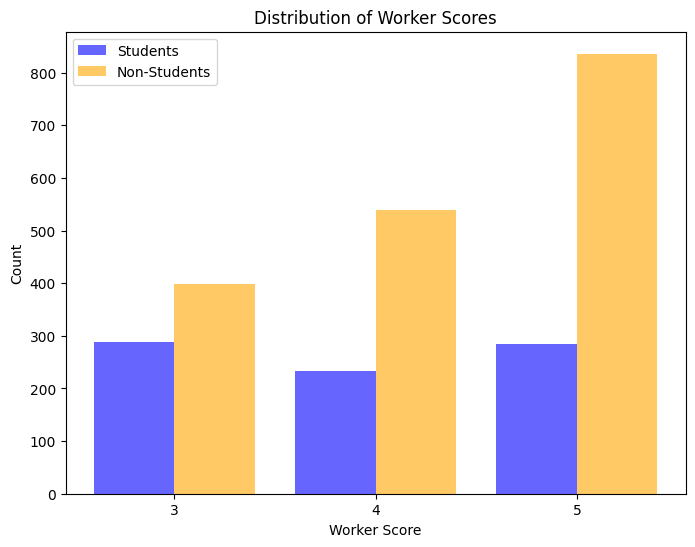

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

score_counts_students = df["Worker.score"].value_counts().sort_index()
score_counts_non_students = df_non_students["Worker.score"].value_counts().sort_index()

categories = sorted(set(score_counts_students.index).union(set(score_counts_non_students.index)))

students_counts_score = [score_counts_students.get(cat, 0) for cat in categories]
non_students_counts_score = [score_counts_non_students.get(cat, 0) for cat in categories]

x = np.arange(len(categories))
width = 0.4

plt.figure(figsize=(8, 6))

plt.bar(x - width/2, students_counts_score, width=width, color="blue", alpha=0.6, label="Students")
plt.bar(x + width/2, non_students_counts_score, width=width, color="orange", alpha=0.6, label="Non-Students")

plt.xlabel("Worker Score")
plt.ylabel("Count")
plt.title("Distribution of Worker Scores")
plt.xticks(x, categories)
plt.legend()
plt.show()


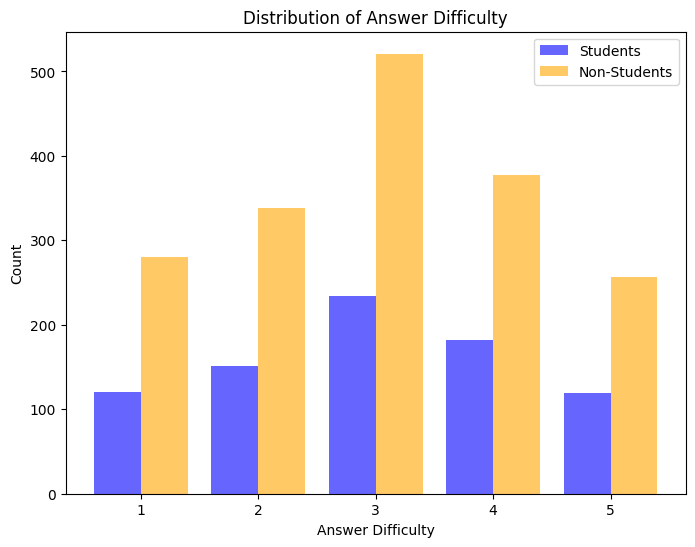

In [ ]:
difficulty_counts_students = df["Answer.difficulty"].value_counts().sort_index()
difficulty_counts_non_students = df_non_students["Answer.difficulty"].value_counts().sort_index()

categories = sorted(set(difficulty_counts_students.index).union(set(difficulty_counts_non_students.index)))

students_counts_difficulty = [difficulty_counts_students.get(cat, 0) for cat in categories]
non_students_counts_difficulty = [difficulty_counts_non_students.get(cat, 0) for cat in categories]

x = np.arange(len(categories))
width = 0.4

plt.figure(figsize=(8, 6))

plt.bar(x - width/2, students_counts_difficulty, width=width, color="blue", alpha=0.6, label="Students")
plt.bar(x + width/2, non_students_counts_difficulty, width=width, color="orange", alpha=0.6, label="Non-Students")

plt.xlabel("Answer Difficulty")
plt.ylabel("Count")
plt.title("Distribution of Answer Difficulty")
plt.xticks(x, categories)
plt.legend()
plt.show()

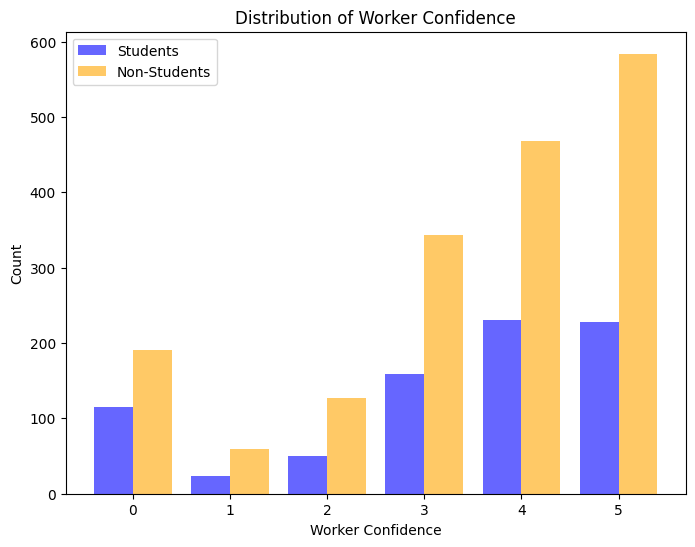

In [ ]:
confidence_counts_students = df["Answer.confidence"].value_counts().sort_index()
confidence_counts_non_students = df_non_students["Answer.confidence"].value_counts().sort_index()

categories = sorted(set(confidence_counts_students.index).union(set(confidence_counts_non_students.index)))

students_counts_confidence = [confidence_counts_students.get(cat, 0) for cat in categories]
non_students_counts_confidence = [confidence_counts_non_students.get(cat, 0) for cat in categories]

x = np.arange(len(categories))
width = 0.4

plt.figure(figsize=(8, 6))

plt.bar(x - width/2, students_counts_confidence, width=width, color="blue", alpha=0.6, label="Students")
plt.bar(x + width/2, non_students_counts_confidence, width=width, color="orange", alpha=0.6, label="Non-Students")

plt.xlabel("Worker Confidence")
plt.ylabel("Count")
plt.title("Distribution of Worker Confidence")
plt.xticks(x, categories)
plt.legend()
plt.show()

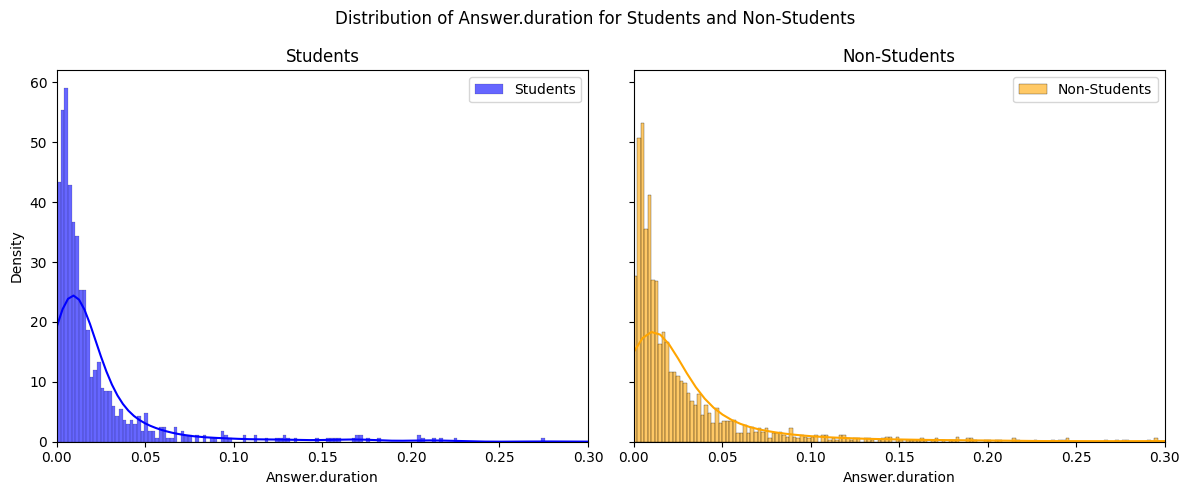

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature = "Answer.duration"

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

sns.histplot(df[feature], bins=300, kde=True, ax=axes[0], color="blue", stat="density", label="Students", alpha=0.6)
axes[0].set_title("Students")
axes[0].set_xlabel(feature.capitalize())
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].set_xlim(0, 0.3)

sns.histplot(df_non_students[feature], bins=500, kde=True, ax=axes[1], color="orange", stat="density", label="Non-Students", alpha=0.6)
axes[1].set_title("Non-Students")
axes[1].set_xlabel(feature.capitalize())
axes[1].legend()
axes[0].set_xlim(0, 0.3)

plt.suptitle(f"Distribution of {feature.capitalize()} for Students and Non-Students")
plt.tight_layout()
plt.show()


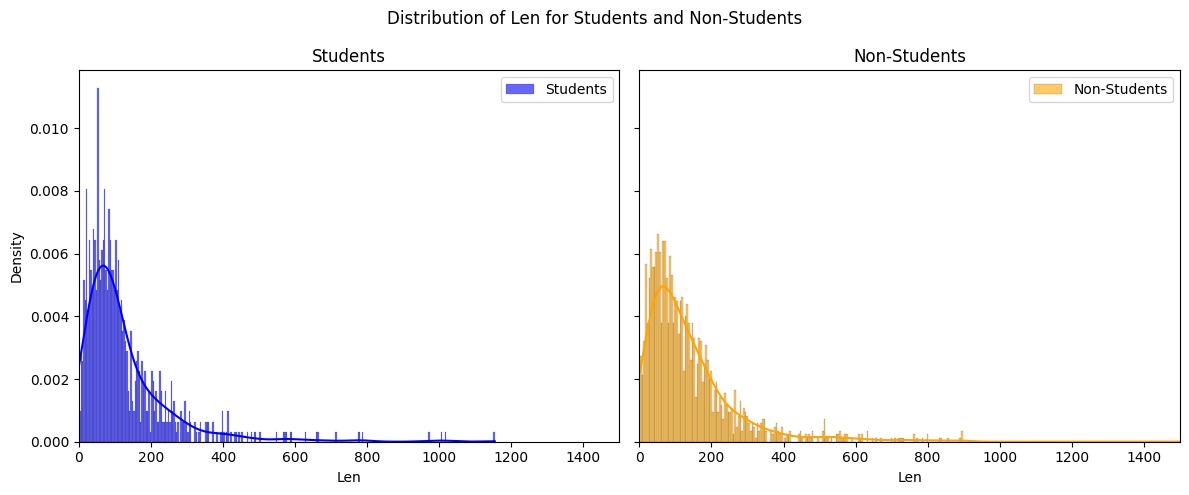

In [ ]:
feature = "len"

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

sns.histplot(df[feature], bins=300, kde=True, ax=axes[0], color="blue", stat="density", label="Students", alpha=0.6)
axes[0].set_title("Students")
axes[0].set_xlabel(feature.capitalize())
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].set_xlim(0, 1500)

sns.histplot(df_non_students[feature], bins=500, kde=True, ax=axes[1], color="orange", stat="density", label="Non-Students", alpha=0.6)
axes[1].set_title("Non-Students")
axes[1].set_xlabel(feature.capitalize())
axes[1].legend()
axes[0].set_xlim(0, 1500)

plt.suptitle(f"Distribution of {feature.capitalize()} for Students and Non-Students")
plt.tight_layout()
plt.show()

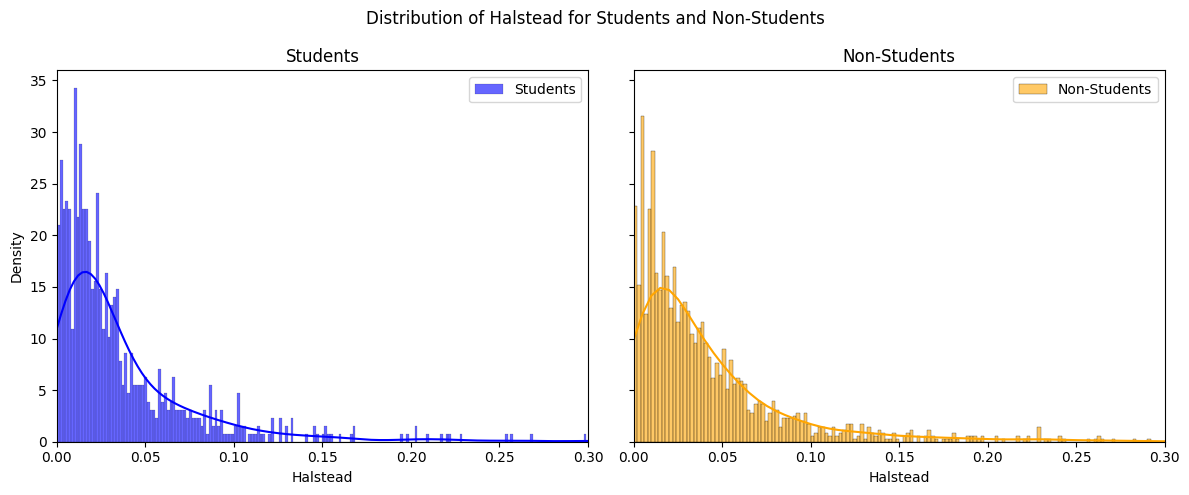

In [ ]:
feature = "halstead"

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

sns.histplot(df[feature], bins=300, kde=True, ax=axes[0], color="blue", stat="density", label="Students", alpha=0.6)
axes[0].set_title("Students")
axes[0].set_xlabel(feature.capitalize())
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].set_xlim(0, 0.3)

sns.histplot(df_non_students[feature], bins=500, kde=True, ax=axes[1], color="orange", stat="density", label="Non-Students", alpha=0.6)
axes[1].set_title("Non-Students")
axes[1].set_xlabel(feature.capitalize())
axes[1].legend()
axes[0].set_xlim(0, 0.3)

plt.suptitle(f"Distribution of {feature.capitalize()} for Students and Non-Students")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import chi2_contingency

features = ["Answer.confidence", "Answer.difficulty", "Worker.score"]
for feature in features:
  students_counts = df[feature].value_counts()
  non_students_counts = df_non_students[feature].value_counts()

  # Ensure all categories appear in both (fill missing categories with 0)
  all_categories = set(students_counts.index).union(set(non_students_counts.index))

  students_counts = students_counts.reindex(all_categories, fill_value=0)
  non_students_counts = non_students_counts.reindex(all_categories, fill_value=0)

  # Create contingency table (each row = class, each column = category)
  obs = np.array([students_counts.values, non_students_counts.values])

  # Perform Chi-Square Test
  chi2, p, dof, expected = chi2_contingency(obs)


  print("Feature: " + feature)
  print(f"Chi-Square Statistic: {chi2}")
  print(f"P-Value: {p}")
  print(f"Degrees of Freedom: {dof}")
  print(f"Expected Frequencies:\n{expected}")
  print("\n")

Feature: Answer.confidence
Chi-Square Statistic: 11.53794259740012
P-Value: 0.04169792306162851
Degrees of Freedom: 5
Expected Frequencies:
[[ 95.71395349  25.96162791  55.36395349 157.33372093 218.64069767
  253.98604651]
 [210.28604651  57.03837209 121.63604651 345.66627907 480.35930233
  558.01395349]]


Feature: Answer.difficulty
Chi-Square Statistic: 0.7419869910751903
P-Value: 0.9460519090512869
Degrees of Freedom: 4
Expected Frequencies:
[[125.42906977 152.95465116 236.15697674 174.85       117.60930233]
 [275.57093023 336.04534884 518.84302326 384.15       258.39069767]]


Feature: Worker.score
Chi-Square Statistic: 54.80676160730699
P-Value: 1.2556336082027438e-12
Degrees of Freedom: 2
Expected Frequencies:
[[214.5744186  241.7872093  350.63837209]
 [471.4255814  531.2127907  770.36162791]]




In [ ]:
from scipy.stats import mannwhitneyu

features = ["len", "halstead", "Answer.duration"]

for feature in features:
    students_data = df[feature]
    non_students_data = df_non_students[feature]

    # Perform Mann-Whitney U Test
    stat, p_value = mannwhitneyu(students_data, non_students_data, alternative='two-sided')

    print(f"Feature: {feature}")
    print(f"Mann-Whitney U Statistic: {stat}")
    print(f"P-Value: {p_value}")
    print("\n")


Feature: len
Mann-Whitney U Statistic: 659901.0
P-Value: 0.0015562292124707733


Feature: halstead
Mann-Whitney U Statistic: 663993.0
P-Value: 0.003378931572312201


Feature: Answer.duration
Mann-Whitney U Statistic: 634895.5
P-Value: 4.445960573926749e-06




In [ ]:
import numpy as np
from scipy.stats import permutation_test

features = ["len", "halstead", "Answer.duration"]

for feature in features:
    students_data = df[feature].values
    non_students_data = df_non_students[feature].values

    # Define the statistic function (difference in medians)
    def statistic(x, y):
        return np.median(x) - np.median(y)

    # Perform Permutation Test
    result = permutation_test((students_data, non_students_data), statistic,
                              alternative='two-sided', permutation_type='independent')

    print(f"Feature: {feature}")
    print(f"Permutation Test Statistic: {result.statistic}")
    print(f"P-Value: {result.pvalue}")
    print("\n")


Feature: len
Permutation Test Statistic: -14.0
P-Value: 0.0016


Feature: halstead
Permutation Test Statistic: -0.004813227714714697
P-Value: 0.0008


Feature: Answer.duration
Permutation Test Statistic: -0.0021886141495023118
P-Value: 0.0014




Text(0.5, 1.0, 'Normalized Distribution of GroundTruth')

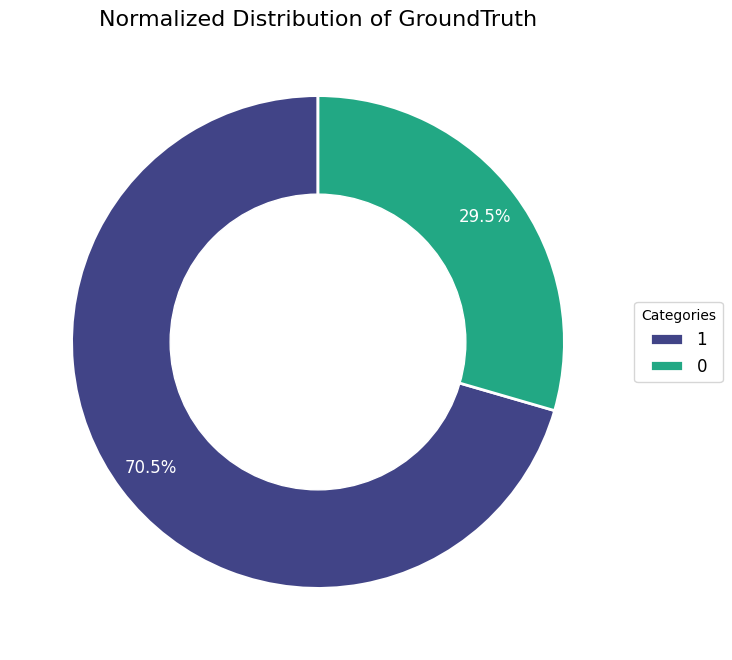

In [ ]:
from matplotlib.colors import to_hex
from matplotlib.cm import viridis

counts = df['GroundTruth'].value_counts(normalize=True)
labels = counts.index
sizes = counts.values

colors = [to_hex(viridis(i)) for i in [0.2, 0.6]]

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=None,
    autopct=lambda p: f'{p:.1f}%',
    startangle=90,
    pctdistance=0.85,
    colors=colors,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)

center_circle = plt.Circle((0, 0), 0.60, color='white')
plt.gca().add_artist(center_circle)

plt.legend(wedges, labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)

plt.title('Normalized Distribution of GroundTruth', fontsize=16)


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

original_size = len(df)
print(original_size)
X = df.drop(columns='GroundTruth')
y = df['GroundTruth']

X_resampled, y_resampled = smote.fit_resample(X, y)

df_smote = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='GroundTruth')], axis=1)

resampled_size = len(X_resampled)
print(resampled_size)
new_samples = resampled_size - original_size


807
1138


Text(0.5, 1.0, 'With SMOTE 331 new samples added.')

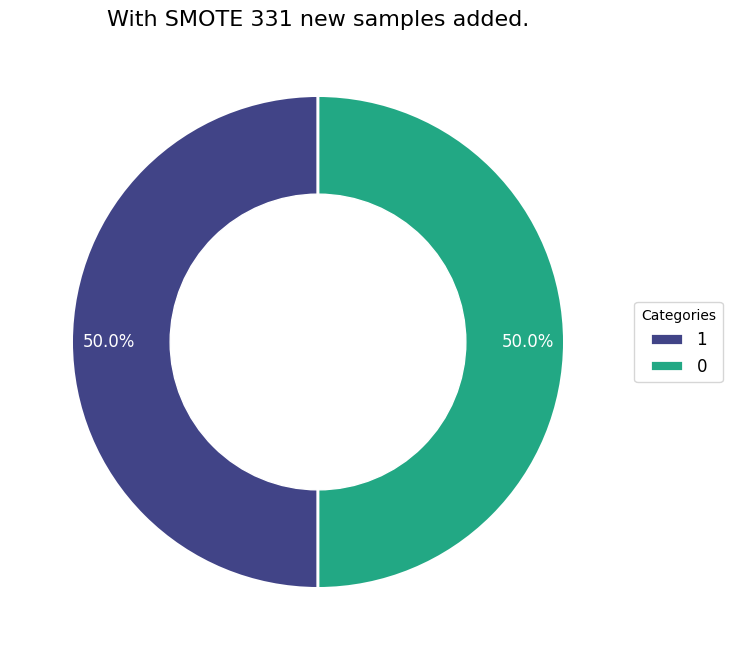

In [ ]:
counts = df_smote['GroundTruth'].value_counts(normalize=True)
labels = counts.index
sizes = counts.values

colors = [to_hex(viridis(i)) for i in [0.2, 0.6]]

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=None,
    autopct=lambda p: f'{p:.1f}%',
    startangle=90,
    pctdistance=0.85,
    colors=colors,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)

center_circle = plt.Circle((0, 0), 0.60, color='white')
plt.gca().add_artist(center_circle)

plt.legend(wedges, labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)

plt.title(f'With SMOTE {new_samples} new samples added.', fontsize=16)

We perform a random sampled 80-20 train-test split. One for the resampled data and one for the original data.

In [ ]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42069)
train_set_smote, test_set_smote = train_test_split(df_smote, test_size=0.2, random_state=42069)

X_train = train_set.drop(['GroundTruth'], axis = 1)
y_train = train_set['GroundTruth']

X_test = test_set.drop(['GroundTruth'], axis = 1)
y_test = test_set['GroundTruth']

X_train_smote = train_set_smote.drop(['GroundTruth'], axis = 1)
y_train_smote = train_set_smote['GroundTruth']

X_test_smote = test_set_smote.drop(['GroundTruth'], axis = 1)
y_test_smote = test_set_smote['GroundTruth']

print(f"            Train Size : {len(X_train)}, Test Size: {len(X_test)}")
print(f"(Resampled) Train Size : {len(X_train_smote)}, Test Size: {len(X_test_smote)}")

            Train Size : 645, Test Size: 162
(Resampled) Train Size : 910, Test Size: 228


## Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist_rf = {
    'n_estimators': [100, 200, 500, 700, 1000],
    'max_depth': [3, 5, 7, 10, 15, 17, 20],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)

random_search_rf = RandomizedSearchCV(
    rf_model, param_distributions=param_dist_rf, n_iter=100, cv=3, scoring='f1', n_jobs=-1, verbose=2, random_state=42
)
random_search_rf_smote = RandomizedSearchCV(
    rf_model, param_distributions=param_dist_rf, n_iter=100, cv=3, scoring='f1', n_jobs=-1, verbose=2, random_state=42
)

random_search_rf.fit(X_train, y_train)
random_search_rf_smote.fit(X_train_smote, y_train_smote)

print("      best hyperparameters for RandomForest:", random_search_rf.best_params_)
print("Smote best hyperparameters for RandomForest:", random_search_rf_smote.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [300, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.1,],
    'max_depth': [2, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.4, 0.6, 0.8],
    'gamma': [0, 0.1, 0.2],
}

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
random_search_xgb = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=100, cv=3, scoring='f1', n_jobs=-1, verbose=2, random_state=42
)
random_search_xgb_smote = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=100, cv=3, scoring='f1', n_jobs=-1, verbose=2, random_state=42
)

random_search_xgb.fit(X_train, y_train)
random_search_xgb_smote.fit(X_train_smote, y_train_smote)
print("      best hyperparameters:", random_search_xgb.best_params_)
print("Smote bwst hyperparameters:", random_search_xgb_smote.best_params_)


In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score
best_xgb = random_search_xgb.best_estimator_
best_rf = random_search_rf.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

best_xgb_smote = random_search_xgb_smote.best_estimator_
best_rf_smote = random_search_rf_smote.best_estimator_
y_pred_xgb_smote = best_xgb_smote.predict(X_test_smote)
y_pred_rf_smote = best_rf_smote.predict(X_test_smote)

print("XGBoost")
test_accuracy_xgb = best_xgb.score(X_test, y_test)
test_recall_xgb = recall_score(y_test, y_pred_xgb)
test_precision_xgb = precision_score(y_test, y_pred_xgb)
test_f1_xgb = f1_score(y_test, y_pred_xgb)
print(f"Test accuracy: {test_accuracy_xgb:.4f}")
print(f"Test recall: {test_recall_xgb:.4f}")
print(f"Test precision: {test_precision_xgb:.4f}")
print(f"Test F1 score: {test_f1_xgb:.4f}")
print("\nXGBoost Smote")
test_accuracy_xgb_smote = best_xgb_smote.score(X_test_smote, y_test_smote)
test_recall_xgb_smote = recall_score(y_test_smote, y_pred_xgb_smote)
test_precision_xgb_smote = precision_score(y_test_smote, y_pred_xgb_smote)
test_f1_xgb_smote = f1_score(y_test_smote, y_pred_xgb_smote)
print(f"Test accuracy: {test_accuracy_xgb_smote:.4f}")
print(f"Test recall: {test_recall_xgb_smote:.4f}")
print(f"Test precision: {test_precision_xgb_smote:.4f}")
print(f"Test F1 score: {test_f1_xgb_smote:.4f}")

print("\nRandom Forest")
test_accuracy_rf = best_rf.score(X_test, y_test)
test_recall_rf = recall_score(y_test, y_pred_rf)
test_precision_rf = precision_score(y_test, y_pred_rf)
test_f1_rf = f1_score(y_test, y_pred_rf)
print(f"Test accuracy: {test_accuracy_rf:.4f}")
print(f"Test recall: {test_recall_rf:.4f}")
print(f"Test precision: {test_precision_rf:.4f}")
print(f"Test F1 score: {test_f1_rf:.4f}")
print("\nRandom Forest Smote")
test_accuracy_rf_smote = best_rf_smote.score(X_test, y_test)
test_recall_rf_smote = recall_score(y_test_smote, y_pred_rf_smote)
test_precision_rf_smote = precision_score(y_test_smote, y_pred_rf_smote)
test_f1_rf_smote = f1_score(y_test_smote, y_pred_rf_smote)
print(f"Test accuracy: {test_accuracy_rf_smote:.4f}")
print(f"Test recall: {test_recall_rf_smote:.4f}")
print(f"Test precision: {test_precision_rf_smote:.4f}")
print(f"Test F1 score: {test_f1_rf_smote:.4f}")

XGBoost
Test accuracy: 0.7469
Test recall: 0.9748
Test precision: 0.7532
Test F1 score: 0.8498

XGBoost Smote
Test accuracy: 0.6974
Test recall: 0.6829
Test precision: 0.7368
Test F1 score: 0.7089

Random Forest
Test accuracy: 0.7346
Test recall: 0.9748
Test precision: 0.7436
Test F1 score: 0.8436

Random Forest Smote
Test accuracy: 0.8889
Test recall: 0.6911
Test precision: 0.7522
Test F1 score: 0.7203


In [ ]:
X_test_non_students = pd.concat([X_test, df_non_students.drop(["GroundTruth"], axis=1)])
y_test_non_students = pd.concat([y_test, df_non_students["GroundTruth"]])
y_pred_xgb_non_students = best_xgb.predict(X_test_non_students)
y_pred_rf_non_students = best_rf.predict(X_test_non_students)

X_test_smote_non_students = pd.concat([X_test_smote, df_non_students.drop(["GroundTruth"], axis=1)])
y_test_smote_non_students = pd.concat([y_test_smote, df_non_students["GroundTruth"]])
y_pred_xgb_smote_non_students = best_xgb_smote.predict(X_test_smote_non_students)
y_pred_rf_smote_non_students = best_rf_smote.predict(X_test_smote_non_students)

print("XGBoost")
test_accuracy_xgb = best_xgb.score(X_test_non_students, y_test_non_students)
test_recall_xgb = recall_score(y_test_non_students, y_pred_xgb_non_students)
test_precision_xgb = precision_score(y_test_non_students, y_pred_xgb_non_students)
print(f"Test accuracy: {test_accuracy_xgb:.4f}")
print(f"Test recall: {test_recall_xgb:.4f}")
print(f"Test precision: {test_precision_xgb:.4f}")
print("\nXGBoost Smote")
test_accuracy_xgb_smote = best_xgb_smote.score(X_test_smote_non_students, y_test_smote_non_students)
test_recall_xgb_smote = recall_score(y_test_smote_non_students, y_pred_xgb_smote_non_students)
test_precision_xgb_smote = precision_score(y_test_smote_non_students, y_pred_xgb_smote_non_students)
print(f"Test accuracy: {test_accuracy_xgb_smote:.4f}")
print(f"Test recall: {test_recall_xgb_smote:.4f}")
print(f"Test precision: {test_precision_xgb_smote:.4f}")

print("\nRandom Forrest")
test_accuracy_rf = best_rf.score(X_test_non_students, y_test_non_students)
test_recall_rf = recall_score(y_test_non_students, y_pred_rf_non_students)
test_precision_rf = precision_score(y_test_non_students, y_pred_rf_non_students)
print(f"Test accuracy: {test_accuracy_rf:.4f}")
print(f"Test recall: {test_recall_rf:.4f}")
print(f"Test precision: {test_precision_rf:.4f}")
print("\nRandom Forrest Smote")
test_accuracy_rf_smote = best_rf_smote.score(X_test_non_students, y_test_non_students)
test_recall_rf_smote = recall_score(y_test_smote_non_students, y_pred_rf_smote_non_students)
test_precision_rf_smote = precision_score(y_test_smote_non_students, y_pred_rf_smote_non_students)
print(f"Test accuracy: {test_accuracy_rf_smote:.4f}")
print(f"Test recall: {test_recall_rf_smote:.4f}")
print(f"Test precision: {test_precision_rf_smote:.4f}")

XGBoost
Test accuracy: 0.7354
Test recall: 0.9888
Test precision: 0.7395

XGBoost Smote
Test accuracy: 0.6332
Test recall: 0.7045
Test precision: 0.7633

Random Forrest
Test accuracy: 0.7359
Test recall: 0.9916
Test precision: 0.7389

Random Forrest Smote
Test accuracy: 0.6465
Test recall: 0.7059
Test precision: 0.7636


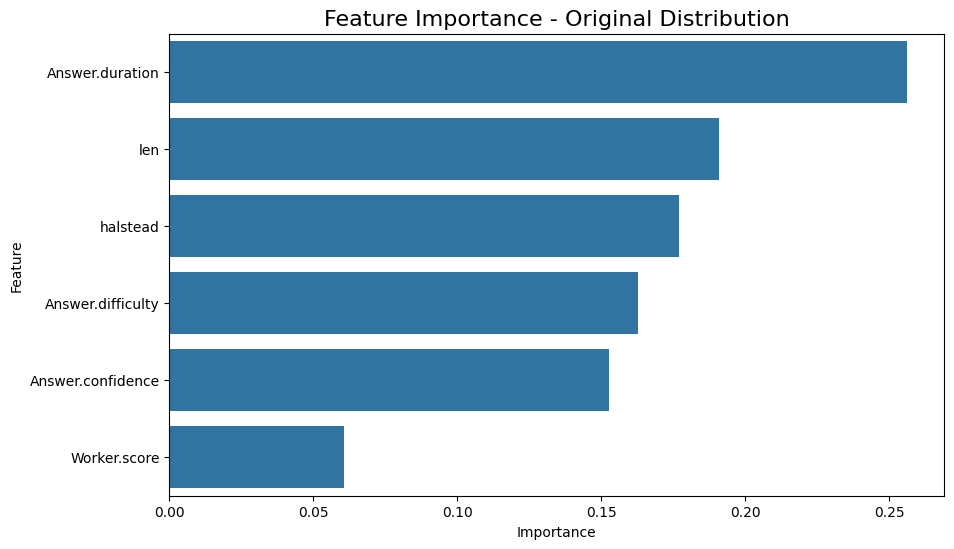

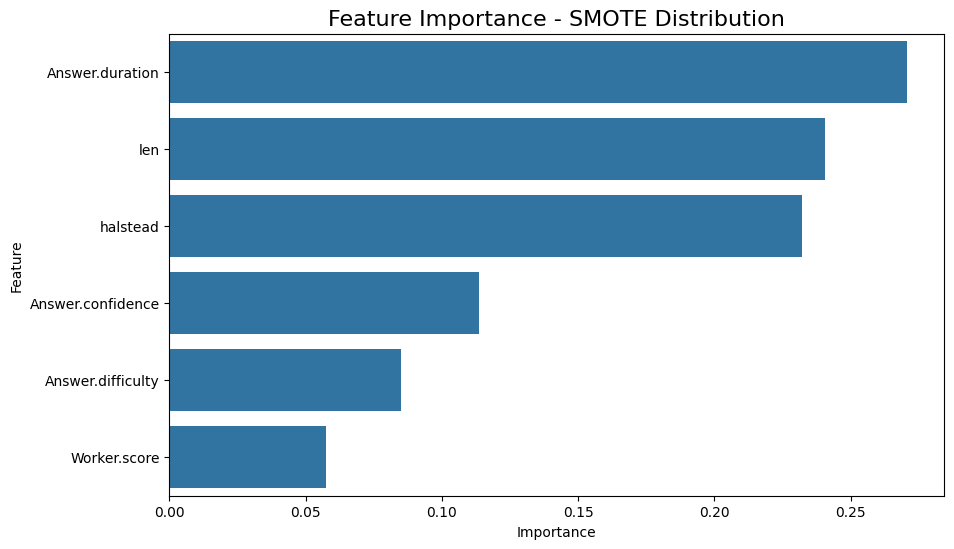

In [ ]:
rf_importance = best_rf.feature_importances_
rf_feature_importance_df = pd.DataFrame(
    {"Feature": X_train.columns,
     "Importance": rf_importance}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=rf_feature_importance_df)
plt.title("Feature Importance - Original Distribution", fontsize=16)
plt.show()

rf_importance_smote = best_rf_smote.feature_importances_
rf_feature_importance_df_smote = pd.DataFrame(
    {"Feature": X_train_smote.columns,
     "Importance": rf_importance_smote}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=rf_feature_importance_df_smote)
plt.title("Feature Importance - SMOTE Distribution", fontsize=16)
plt.show()

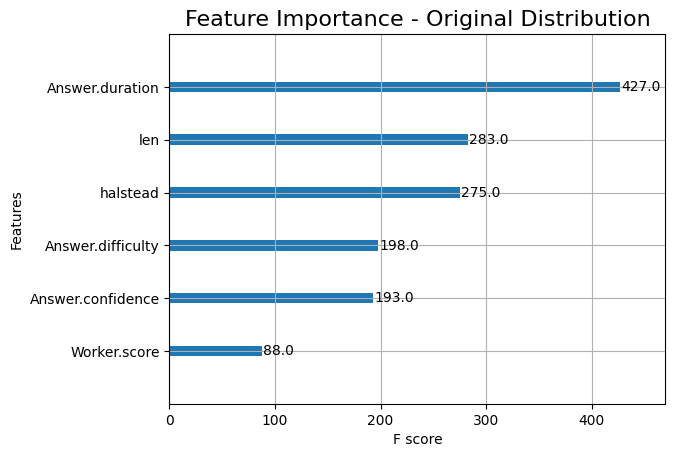

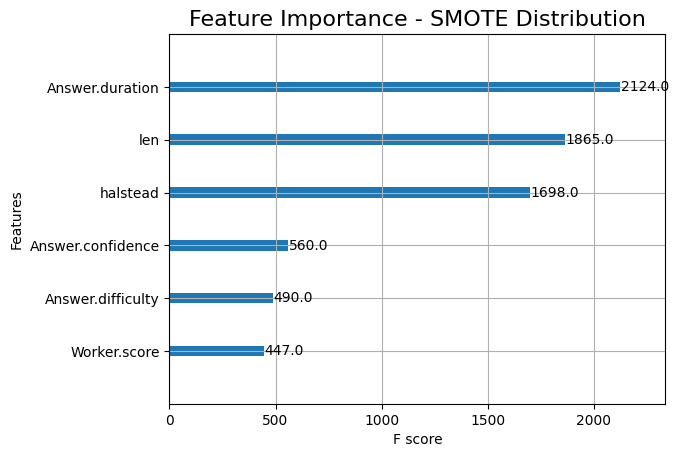

In [ ]:
from xgboost import plot_importance

plot_importance(best_xgb)
plt.title("Feature Importance - Original Distribution", fontsize=16)
plot_importance(best_xgb_smote)
plt.title("Feature Importance - SMOTE Distribution", fontsize=16)
plt.show()

In [ ]:
accuracy_list_xgb = []
recall_list_xgb = []
precision_list_xgb = []
accuracy_list_rf = []
recall_list_rf = []
precision_list_rf = []
X_test_new = X_test
y_test_new = y_test

accuracy_list_xgb_smote = []
recall_list_xgb_smote = []
precision_list_xgb_smote = []
accuracy_list_rf_smote = []
recall_list_rf_smote = []
precision_list_rf_smote = []
X_test_new_smote = X_test_smote
y_test_new_smote = y_test_smote

for i in range(0, len(df_non_students)):
  X_test_new = pd.concat([X_test_new, df_non_students.iloc[[i]].drop(columns="GroundTruth")], ignore_index=True)
  y_test_new = pd.concat([y_test_new, pd.Series([df_non_students.iloc[i]["GroundTruth"]])], ignore_index=True)
  X_test_new_smote = pd.concat([X_test_new_smote, df_non_students.iloc[[i]].drop(columns="GroundTruth")], ignore_index=True)
  y_test_new_smote = pd.concat([y_test_new_smote, pd.Series([df_non_students.iloc[i]["GroundTruth"]])], ignore_index=True)

  # Test on new test set
  y_pred_xgb = best_xgb.predict(X_test_new)
  y_pred_rf = best_rf.predict(X_test_new)

  y_pred_xgb_smote = best_xgb_smote.predict(X_test_new_smote)
  y_pred_rf_smote = best_rf_smote.predict(X_test_new_smote)

  # XGBoost
  test_accuracy_xgb = best_xgb.score(X_test_new, y_test_new)
  accuracy_list_xgb.append(test_accuracy_xgb)
  test_recall_xgb = recall_score(y_test_new, y_pred_xgb)
  recall_list_xgb.append(test_recall_xgb)
  test_precision_xgb = precision_score(y_test_new, y_pred_xgb)
  precision_list_xgb.append(test_precision_xgb)

  test_accuracy_xgb_smote = best_xgb.score(X_test_new_smote, y_test_new_smote)
  accuracy_list_xgb_smote.append(test_accuracy_xgb_smote)
  test_recall_xgb_smote = recall_score(y_test_new_smote, y_pred_xgb_smote)
  recall_list_xgb_smote.append(test_recall_xgb_smote)
  test_precision_xgb_smote = precision_score(y_test_new_smote, y_pred_xgb_smote)
  precision_list_xgb_smote.append(test_precision_xgb_smote)

  # Random Forrest
  test_accuracy_rf = best_rf.score(X_test_new, y_test_new)
  accuracy_list_rf.append(test_accuracy_rf)
  test_recall_rf = recall_score(y_test_new, y_pred_rf)
  recall_list_rf.append(test_recall_rf)
  test_precision_rf = precision_score(y_test_new, y_pred_rf)
  precision_list_rf.append(test_precision_rf)

  test_accuracy_rf_smote = best_rf.score(X_test_new_smote, y_test_new_smote)
  accuracy_list_rf_smote.append(test_accuracy_rf_smote)
  test_recall_rf_smote = recall_score(y_test_new_smote, y_pred_rf_smote)
  recall_list_rf_smote.append(test_recall_rf_smote)
  test_precision_rf_smote = precision_score(y_test_new_smote, y_pred_rf_smote)
  precision_list_rf_smote.append(test_precision_rf_smote)

  if True or i < 10 or (i % 100 == 0):
    print("Round: ", i)
    print(len(y_test_new))
    print(test_accuracy_xgb, test_accuracy_rf)
    print(test_precision_xgb, test_precision_rf)
    print(test_recall_xgb, test_recall_rf)
    print("\n")
    print(len(y_test_new_smote))
    print(test_accuracy_xgb_smote, test_accuracy_rf_smote)
    print(test_precision_xgb_smote, test_precision_rf_smote)
    print(test_recall_xgb_smote, test_recall_rf_smote)
    print("\n\n")


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.


Round:  1416
1579
0.727675744141862 0.7283090563647878
0.731785944551902 0.7313624678663239
0.9878154917319408 0.9904264577893821


1645
0.703951367781155 0.705775075987842
0.7533081285444234 0.7507055503292568
0.6912402428447528 0.6921075455333912



Round:  1417
1580
0.7278481012658228 0.7284810126582278
0.7319587628865979 0.7315350032113038
0.9878260869565217 0.9904347826086957


1646
0.704131227217497 0.7059538274605103
0.7533081285444234 0.7509398496240601
0.6906412478336221 0.6923743500866552



Round:  1418
1581
0.7280202403542062 0.7286527514231499
0.7321313586606568 0.7317073170731707
0.9878366637706343 0.9904430929626412


1647
0.7043108682452944 0.7061323618700668
0.7535410764872521 0.7511737089201878
0.6909090909090909 0.6926406926406926



Round:  1419
1582
0.7281921618204804 0.7288242730720607
0.7323037323037324 0.731879409878127
0.9878472222222222 0.9904513888888888


1648
0.7044902912621359 0.706310679

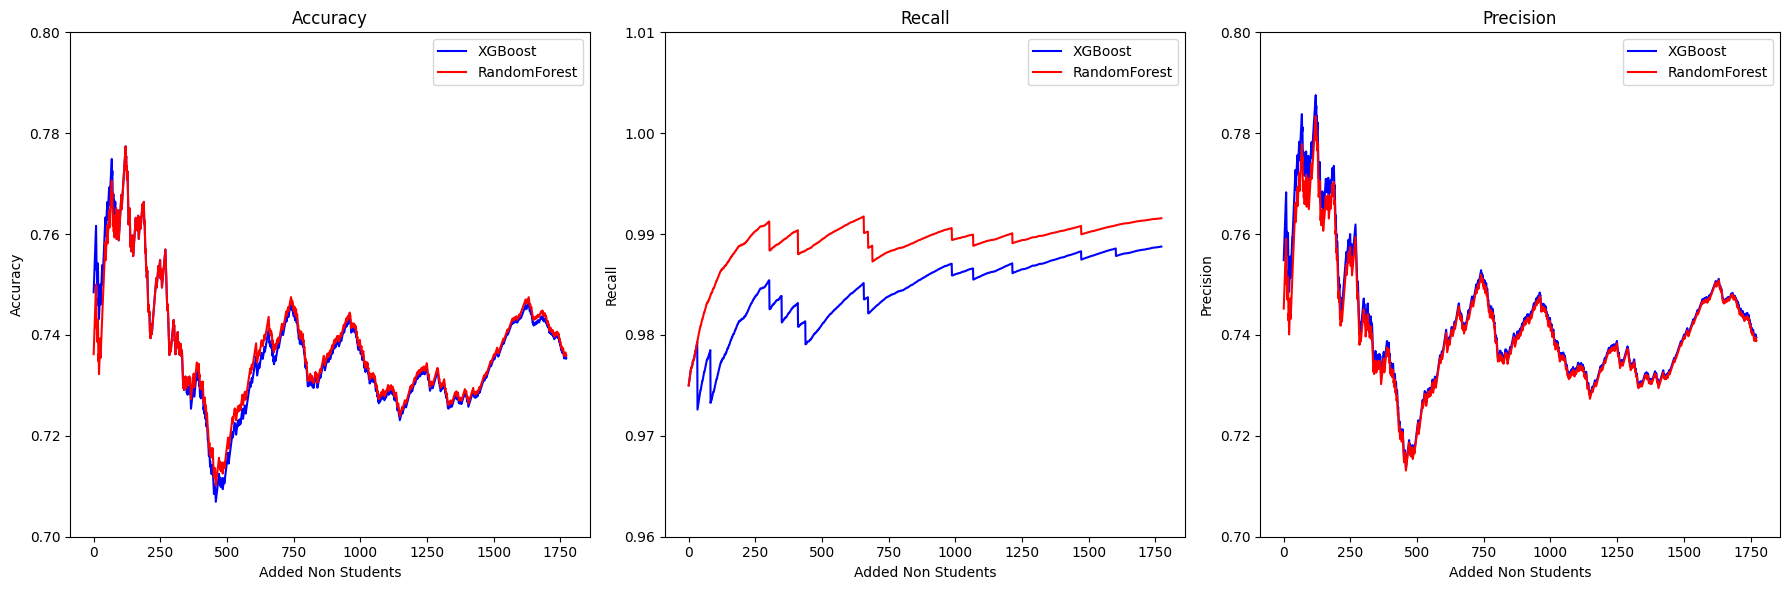

In [ ]:
added_non_students = list(range(0, len(recall_list_xgb)))

# Create a DataFrame with columns for both models
df_metrics = pd.DataFrame({
    'Added Non Students': added_non_students,
    'Accuracy_XGB': accuracy_list_xgb,
    'Recall_XGB': recall_list_xgb,
    'Precision_XGB': precision_list_xgb,
    'Accuracy_RF': accuracy_list_rf,
    'Recall_RF': recall_list_rf,
    'Precision_RF': precision_list_rf,
})

sns.set_palette("Blues_d")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Accuracy
sns.lineplot(x='Added Non Students', y='Accuracy_XGB', data=df_metrics, ax=axes[0], color="blue", label="XGBoost", marker=None)
sns.lineplot(x='Added Non Students', y='Accuracy_RF', data=df_metrics, ax=axes[0], color="red", label="RandomForest", marker=None)
axes[0].set_title('Accuracy')
axes[0].set_ylim(0.7, 0.8)
axes[0].set_xlabel('Added Non Students')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot Recall
sns.lineplot(x='Added Non Students', y='Recall_XGB', data=df_metrics, ax=axes[1], color="blue", label="XGBoost", marker=None)
sns.lineplot(x='Added Non Students', y='Recall_RF', data=df_metrics, ax=axes[1], color="red", label="RandomForest", marker=None)
axes[1].set_title('Recall')
axes[1].set_ylim(0.96, 1.01)
axes[1].set_xlabel('Added Non Students')
axes[1].set_ylabel('Recall')
axes[1].legend()

# Plot Precision
sns.lineplot(x='Added Non Students', y='Precision_XGB', data=df_metrics, ax=axes[2], color="blue", label="XGBoost", marker=None)
sns.lineplot(x='Added Non Students', y='Precision_RF', data=df_metrics, ax=axes[2], color="red", label="RandomForest", marker=None)
axes[2].set_title('Precision')
axes[2].set_ylim(0.7, 0.8)
axes[2].set_xlabel('Added Non Students')
axes[2].set_ylabel('Precision')
axes[2].legend()

plt.tight_layout()
plt.show()


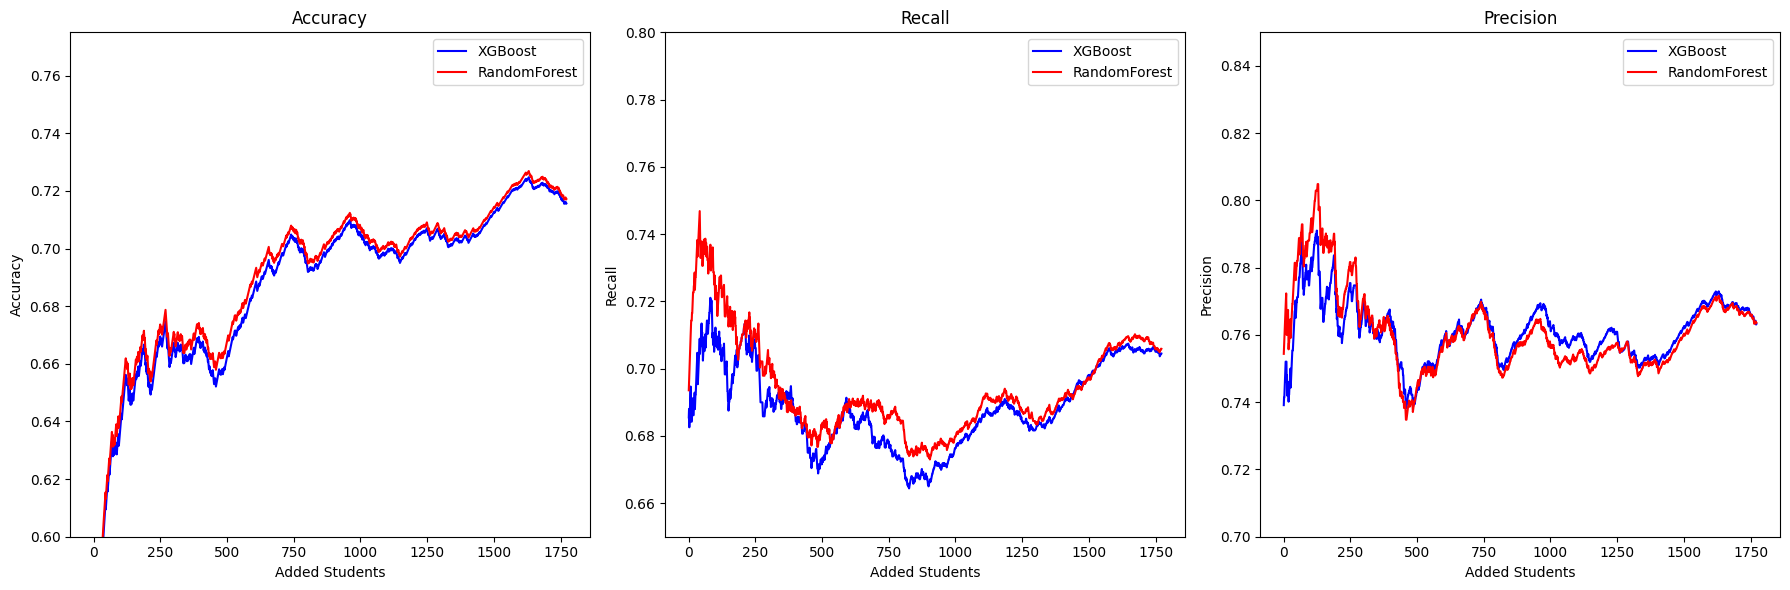

In [ ]:
added_students_smote = list(range(0, len(recall_list_xgb_smote)))

# Create a DataFrame with columns for both models
df_metrics_smote = pd.DataFrame({
    'Added Students': added_students_smote,
    'Accuracy_XGB': accuracy_list_xgb_smote,
    'Recall_XGB': recall_list_xgb_smote,
    'Precision_XGB': precision_list_xgb_smote,
    'Accuracy_RF': accuracy_list_rf_smote,
    'Recall_RF': recall_list_rf_smote,
    'Precision_RF': precision_list_rf_smote,
})

sns.set_palette("Blues_d")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Accuracy
sns.lineplot(x='Added Students', y='Accuracy_XGB', data=df_metrics_smote, ax=axes[0], color="blue", label="XGBoost", marker=None)
sns.lineplot(x='Added Students', y='Accuracy_RF', data=df_metrics_smote, ax=axes[0], color="red", label="RandomForest", marker=None)
axes[0].set_title('Accuracy')
axes[0].set_ylim(0.6, 0.775)
axes[0].set_xlabel('Added Students')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot Recall
sns.lineplot(x='Added Students', y='Recall_XGB', data=df_metrics_smote, ax=axes[1], color="blue", label="XGBoost", marker=None)
sns.lineplot(x='Added Students', y='Recall_RF', data=df_metrics_smote, ax=axes[1], color="red", label="RandomForest", marker=None)
axes[1].set_title('Recall')
axes[1].set_ylim(0.65, 0.8)
axes[1].set_xlabel('Added Students')
axes[1].set_ylabel('Recall')
axes[1].legend()

# Plot Precision
sns.lineplot(x='Added Students', y='Precision_XGB', data=df_metrics_smote, ax=axes[2], color="blue", label="XGBoost", marker=None)
sns.lineplot(x='Added Students', y='Precision_RF', data=df_metrics_smote, ax=axes[2], color="red", label="RandomForest", marker=None)
axes[2].set_title('Precision')
axes[2].set_ylim(0.7, 0.85)
axes[2].set_xlabel('Added Students')
axes[2].set_ylabel('Precision')
axes[2].legend()

plt.tight_layout()
plt.show()


# TASK **2**

In [ ]:
!pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

We select 1 bug type randomly from our bugtypes and use it for our experiments. We filter out false positives and false negatives in order to only test on correct data. Additionaly, we drop samples were the GroundTruth not match the answer option (like task 1).

In [ ]:
import random
data = pd.read_csv("./data/answerList_data.csv")
data = data.drop(["Answer.ID", "Question.ID", "TP", "TN", "Answer.option", "Answer.order", "Code.LOC", "Code.complexity", "Worker.ID", "Worker.yearsOfExperience", "Worker.age", "Worker.gender", "Worker.whereLearnedToCode", "Worker.country", "Worker.programmingLanguage"], axis=1)

bug_types = ["HIT01_8", "HIT02_24", "HIT03_6", "HIT04_7", "HIT05_35", "HIT06_51", "HIT07_33", "HIT08_54"]

# random_samples = random.sample(bug_types, 1)
random_samples = ["HIT07_33"]
for bug in random_samples:
    print(bug)
    filtered_data = data[data['FailingMethod'].isin([bug])]
    filtered_data = filtered_data[filtered_data['FP'] != 1]
    filtered_data = filtered_data[filtered_data['FN'] != 1]
    filtered_data = filtered_data[filtered_data['GroundTruth'] == 1]

HIT07_33


For want to order the explanations to that we use the explanation with the highest halstead score first for the LLM consolidation.

We also tried random sampling and compare it to the heuristic sampling based on halstead volume to compare the efficiency.


In [ ]:
filtered_data['halstead'] = filtered_data['Answer.explanation'].apply(lambda x: calculate_halstead(x))
min_value = filtered_data['halstead'].min()
max_value = filtered_data['halstead'].max()
filtered_data['halstead'] = filtered_data['halstead'].apply(lambda x: (x - min_value) / (max_value - min_value))

sorted_data = filtered_data.sort_values(by="halstead", ascending=False)

NameError: name 'calculate_halstead' is not defined

In [ ]:
from bert_score import score
from openai import OpenAI
import time

In [ ]:
from google.colab import userdata
OPEN_AI_KEY = userdata.get('OPENAI')

# Create the client here or do the prompting manually
client = OpenAI(api_key=OPEN_AI_KEY)

def get_formatted_prompt(explanations, prompt_text):
    """
    Given a batch of human explanations and a prompt_text,
    returns the formatted prompt for the LLM.
    """
    explanation_text = ""
    for exp in explanations:
        explanation_text += exp + "\n\n"

    # Build a full prompt, combining the "prompt_text" plus the actual explanations
    full_prompt = f"""{prompt_text}

Here are the explanations, each separated by a newline:
{explanation_text}
"""
    return full_prompt


def get_llm_consolidation(explanations, prompt_text):
    """
    Given a batch of human explanations and a prompt_text,
    calls the LLM to generate a consolidated explanation.
    """

    full_prompt = get_formatted_prompt(explanations, prompt_text)

    try:
        time.sleep(2)
        response = client.chat.completions.create(
            messages=[{"role": "user", "content": full_prompt}],
            model="gpt-4o-mini",
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print("OpenAI API call failed:", e)
        return None

In [ ]:
# LLM prompt
gpt_prompt = """Programmers have provided bug explanations.
Your goal is to unify them into a single, clear explanation that keeps necessary
technical details but avoids repeating the same info. Provide a short summary
focusing on the steps needed to fix the bug. Avoid headings or special formatting."""

# Handwritten GroundTruth for HIT07_33
reference = """In line 910, array[i] is accessed without first checking if it's null,
leading to a NullPointerException when getClass() is called on a null value.
For instance if the input array contains a null value, such as in the case
new Object[]{"Test", null, 99d}, the second element (index 1) is null,
and getClass() on array[i] at that index will throw the exception.
To fix the bug, add a null check before invoking getClass() on array[i].
Update line 910 to: 'classes[i] = array[i] == null ? null : array[i].getClass();'."""

# Reformat string
reference= reference.replace("\n", " ")


If you don't want to use the API you can use this template:


In [ ]:
F1_score_threshold = 0.9
F1_score = 0
P = 0
R = 0
explanations_count = 0
# Sorted explanations
for i in range(1, len(sorted_data)):
  candidates = sorted_data["Answer.explanation"]

  # Request LLM to consolidate given explanations
  consolidated_candidate = get_llm_consolidation(candidates[:i], gpt_prompt)

  # Compute BERTScore (default model is 'bert-base-uncased')
  P, R, F1_score = score(consolidated_candidate, reference, lang='en', verbose=True)

  explanations_count = i

  print(F1_score)
  # Stop after threshold is reached
  if F1_score >= F1_score_threshold:
      break

print("Consolidated Explanation: ", consolidated_candidate)
print("\n\n")
print("SORTED DATA")
print("Consolidated examples: ", explanations_count)
print("\nSCORES\n")
print("F1 score: ", F1_score)
print("Precision: ", P)
print("Recall: ", R)
print("\n\n")

The issue is actually with the use of one of the members of the array variable. On line 910; there is no check for whether array[i] is null before array[i] is dereferenced; the second member of the test input array is null; causing the exception to be thrown.


OpenAI API call failed: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


TypeError: object of type 'NoneType' has no len()

In [ ]:

F1_score_baseline_sum = 0
P_baseline_sum = 0
R_baseline_sum = 0
explanations_count_baseline_sum = 0
base_line_samples = 5
for sample in range(0, base_line_samples)
  # Reset scores before each random sample
  F1_score_baseline = 0
  P_baseline = 0
  R_baseline = 0
  explanations_count_baseline = 0

  # Shuffle data for random sampling explanations
  shuffled_data = filtered_data.sample(frac=1).reset_index(drop=True)

  for i in range(1, len(filtered_data)):
    candidates = shuffled_data["Answer.explanation"]

    # Request LLM to consolidate given explanations
    consolidated_candidate = get_llm_consolidation(candidates[:i], gpt_prompt)

    # Compute BERTScore (default model is 'bert-base-uncased')
    P_baseline, R_baseline, F1_score_baseline = score(consolidated_candidate, reference, lang='en', verbose=True)

    explanations_count_baseline = i

    # Stop after threshold is reached
    if F1_score_baseline > F1_score_threshold:
      break

  F1_score_baseline_sum += F1_score_baseline
  P_baseline_sum += P_baseline
  R_baseline_sum = R_baseline
  explanations_count_baseline_sum = explanations_count_baseline

print("RANDOM BASELINE")
print("Consolidated Exaples: ", explanations_count_baseline_sum / base_line_samples)
print("\nSCORES\n")
print("F1: ", F1_score_baseline_sum / base_line_samples)
print("Precision: ", P_baseline_sum / base_line_samples)
print("Recall: ", R_baseline_sum / base_line_samples)
print("\n\n")

In [ ]:
# Shuffle data for baseline
shuffled_data = filtered_data.sample(frac=1).reset_index(drop=True)

In [ ]:
# Without API
# Increase sample_count, paste prompt to llm and compute scores
# Don't forget to note the scores down before going on
sample_count = 2
candidates = sorted_data["Answer.explanation"]
# candidates = shuffled_data["Answer.explanation"]
print(get_formatted_prompt(candidates[:sample_count], gpt_prompt))


Programmers have provided bug explanations. 
Your goal is to unify them into a single, clear explanation that keeps necessary 
technical details but avoids repeating the same info. Provide a short summary 
focusing on the steps needed to fix the bug. Avoid headings or special formatting.

Here are the explanations, each separated by a newline:
The issue is actually with the use of one of the members of the array variable. On line 910; there is no check for whether array[i] is null before array[i] is dereferenced; the second member of the test input array is null; causing the exception to be thrown.

As we iterate through Object's dimensions; there are null arrays in the middle. getClass doesn't work on nulls and throws a NullPointerException. You might try testing for these nulls at line 910 like so:    classes[i] = array[i] == null ? null : array[i].getClass();





In [ ]:
consolidated_candidate = """
The bug occurs because the code attempts to call getClass() on a null element in the array, which results in a NullPointerException. The issue arises when the loop reaches an element that is null, particularly when array[i] == null. To fix the bug, add a null check before calling getClass() on the array element. Specifically, replace classes[i] = array[i].getClass(); with classes[i] = array[i] == null ? null : array[i].getClass(); to prevent the exception from being thrown when a null is encountered. Additionally, ensure the array is properly initialized and that any null values are handled correctly throughout the code.
"""

P, R, F1_score = score([consolidated_candidate], [reference], lang='en', verbose=True)

print("SORTED DATA")
print("Consolidated examples: ", sample_count)
print("\nSCORES\n")
print("F1 score: ", F1_score)
print("Precision: ", P)
print("Recall: ", R)
print("\n\n")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 4.06 seconds, 0.25 sentences/sec
SORTED DATA
Consolidated examples:  20

SCORES

F1 score:  tensor([0.9052])
Precision:  tensor([0.9138])
Recall:  tensor([0.8967])





## Sorted Explanations

#### Metrics Summary

| Number of Explanations | F1_score | Precision | Recall |
|------------------------|----------|-----------|--------|
| 1                      | 0.8925   | 0.9159    | 0.8703 |
| 2                      | 0.9084   | 0.9216    | 0.8956 |

---


#### Final Consolidated Prompt

The bug is caused by dereferencing a null array element at line 910. Specifically, the second element in the input array is null, which causes a `NullPointerException`.

To fix this, add a check to ensure the array element is not null before accessing it. You can modify the code like this:

```java
classes[i] = array[i] == null ? null : array[i].getClass();




## Random Baseline Explanations

#### Metrics Summary

| Number of Explanations | F1_score | Precision | Recall |
|------------------------|----------|-----------|--------|
| 1                      | 0.8930   | 0.9192    | 0.8683 |
| 2                      | 0.8908   | 0.9155    | 0.8673 |
| 3                      | 0.8776   | 0.8880    | 0.8674 |
| 4                      | 0.8748   | 0.8855    | 0.8643 |
| 5                      | 0.8838   | 0.8931    | 0.8747 |
| 6                      | 0.8804   | 0.8898    | 0.8712 |
| 7                      | 0.8873   | 0.9013    | 0.8736 |
| 8                      | 0.8908   | 0.9045    | 0.8776 |
| 9                      | 0.8810   | 0.8872    | 0.8748 |
| 10                     | 0.8867   | 0.9011    | 0.8729 |
| 11                     | 0.8803   | 0.8867    | 0.8740 |
| 12                     | 0.8838   | 0.8906    | 0.8771 |
| 13                     | 0.8837   | 0.8912    | 0.8762 |
| 14                     | 0.8794   | 0.8852    | 0.8736 |
| 15                     | 0.8897   | 0.8953    | 0.8843 |
| 16                     | 0.8832   | 0.9091    | 0.8588 |
| 17                     | 0.8881   | 0.9028    | 0.8738 |
| 18                     | 0.8849   | 0.9040    | 0.8665 |
| 19                     | 0.8934   | 0.9072    | 0.8800 |
| 20                     | 0.9052   | 0.9138    | 0.8967 |
| -                      | -        | -         | -      |
| 1                      | 0.8709   | 0.8857    | 0.8565 |
| 2                      | 0.8665   | 0.8852    | 0.8486 |
| 3                      | 0.8779   | 0.8894    | 0.8668 |
| 4                      | 0.8582   | 0.8775    | 0.8397 |
| 5                      | 0.8564   | 0.8785    | 0.8353 |
| 6                      | 0.8802   | 0.9007    | 0.8605 |
| 7                      | 0.8829   | 0.9021    | 0.8646 |
| 8                      | 0.8746   | 0.8922    | 0.8577 |
| 9                      | 0.8840   | 0.9081    | 0.8611 |
| 10                     | 0.8807   | 0.9018    | 0.8606 |
| 11                     | 0.9192   | 0.9266    | 0.9120 |
| -                      | -        | -         | -      |
| 1                      | 0.8789   | 0.9093    | 0.8505 |
| 2                      | 0.8821   | 0.9041    | 0.8612 |
| 3                      | 0.8872   | 0.9075    | 0.8678 |
| 4                      | 0.9018   | 0.9303    | 0.8750 |
| -                      | -        | -         | -      |


---


#### Final Consolidated Prompt

The bug occurs because the code attempts to call getClass() on a null element in the array, which results in a NullPointerException. The issue arises when the loop reaches an element that is null, particularly when array[i] == null. To fix the bug, add a null check before calling getClass() on the array element. Specifically, replace classes[i] = array[i].getClass(); with classes[i] = array[i] == null ? null : array[i].getClass(); to prevent the exception from being thrown when a null is encountered. Additionally, ensure the array is properly initialized and that any null values are handled correctly throughout the code.




### Conclusion
Bug Type: HIT_07_33
<br>
##### Sorted
--> Already after 2 explanations were a above the threshold of 0.9

##### Random Baseline
--> over 3 samples
--> mean explanation needed were (20 + 11 + 4) / 3 = 11.67 ~ 12 to beat threshold 0.9

In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.7 MB/s eta 0:00:00


### Readability
Now we want to also check the readbility scores of our two prompts. Therefore we utilize the **Flesch Reading Ease Score** and the Flesch Kincaid Grade Level as metrics. In general we aim for a general and fairly easy explanations, which mean we aim for a Flesch Reading Ease Score of over 60. Additionally we want that the explanation is understanable and clear for programmers with indermediate programming skills expecting a **Flesch-Kincaid Grade Level** between 8 to 12.

In [ ]:
import textstat
prompt_sorted = """
The bug is caused by dereferencing a null array element at line 910. Specifically, the second element in the input array is null, which causes a `NullPointerException`.

To fix this, add a check to ensure the array element is not null before accessing it. You can modify the code like this:

```java
classes[i] = array[i] == null ? null : array[i].getClass();
"""
prompt_random =  """
The bug occurs because the code attempts to call getClass() on a null element in the array, which results in a NullPointerException. The issue arises when the loop reaches an element that is null, particularly when array[i] == null. To fix the bug, add a null check before calling getClass() on the array element. Specifically, replace classes[i] = array[i].getClass(); with classes[i] = array[i] == null ? null : array[i].getClass(); to prevent the exception from being thrown when a null is encountered. Additionally, ensure the array is properly initialized and that any null values are handled correctly throughout the code.
"""

fre_score = textstat.flesch_reading_ease(prompt_sorted)
fre_level = textstat.flesch_kincaid_grade(prompt_sorted)
print("Sorted: ", fre_score, fre_level)
fre_score_random = textstat.flesch_reading_ease(prompt_random)
fre_level_random = textstat.flesch_kincaid_grade(prompt_random)
print("Random: ", fre_score_random, fre_level_random)

The Readabily Scores did not match the expected threshold, so we try to adapt the gpt base prompt and add the following line:

*Additionally, aim for a Flesch Reading Ease Score between 60 and 80, and a
Flesch-Kincaid Grade Level between 8 and 12.*

Since we have already demonstrated that the sorted version yields significantly better and faster results on the Similarity Score compared to our Ground Truth Label, we will continue using the sorted variant, as it is also easier to work with.


In [ ]:
# LLM prompt
gpt_prompt = """Programmers have provided bug explanations.
Your goal is to unify them into a single, clear explanation that keeps necessary
technical details but avoids repeating the same info. Provide a short summary
focusing on the steps needed to fix the bug. Avoid headings or special formatting.
Additionally, aim for a Flesch Reading Ease Score between 60 and 80, and a
Flesch-Kincaid Grade Level between 8 and 12."""

sample_count = 3
candidates = sorted_data["Answer.explanation"]
print(get_formatted_prompt(candidates[:sample_count], gpt_prompt))


Programmers have provided bug explanations.
Your goal is to unify them into a single, clear explanation that keeps necessary
technical details but avoids repeating the same info. Provide a short summary
focusing on the steps needed to fix the bug. Avoid headings or special formatting.
Additionally, aim for a Flesch Reading Ease Score between 60 and 80, and a
Flesch-Kincaid Grade Level between 8 and 12.

Here are the explanations, each separated by a newline:
The issue is actually with the use of one of the members of the array variable. On line 910; there is no check for whether array[i] is null before array[i] is dereferenced; the second member of the test input array is null; causing the exception to be thrown.

As we iterate through Object's dimensions; there are null arrays in the middle. getClass doesn't work on nulls and throws a NullPointerException. You might try testing for these nulls at line 910 like so:    classes[i] = array[i] == null ? null : array[i].getClass();

The for

In [ ]:
consolidated_candidate = """
The issue arises because the code does not check if array[i] is null before trying to access it on line 910. This causes a NullPointerException when array[i] is null, as in the case with the second member of the test input array. To fix this, modify the code to check for null values before dereferencing the array element. For example, you can use a conditional statement like this: classes[i] = array[i] == null ? null : array[i].getClass();. This ensures that getClass is only called when array[i] is not null.
"""

P, R, F1_score = score([consolidated_candidate], [reference], lang='en', verbose=True)
fre_score = textstat.flesch_reading_ease(consolidated_candidate)
fre_level = textstat.flesch_kincaid_grade(consolidated_candidate)

print("SORTED DATA")
print("Consolidated examples: ", sample_count)
print("\nSCORES\n")
print("F1 score: ", F1_score)
print("Precision: ", P)
print("Recall: ", R)
print("\n\n")

print("Readability: ", fre_score, fre_level)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 7.32 seconds, 0.14 sentences/sec
SORTED DATA
Consolidated examples:  3

SCORES

F1 score:  tensor([0.9142])
Precision:  tensor([0.9189])
Recall:  tensor([0.9095])



Readability:  62.68 8.7


After 3 explanations we get a suitable result:

> Blockzitat einfügen


<br><br>

The issue arises because the code does not check if array[i] is null before trying to access it on line 910. This causes a NullPointerException when array[i] is null, as in the case with the second member of the test input array. To fix this, modify the code to check for null values before dereferencing the array element. For example, you can use a conditional statement like this: classes[i] = array[i] == null ? null : array[i].getClass();. This ensures that getClass is only called when array[i] is not null.

<br>

| Number of Explanations | F1_score | Precision | Recall | FRE_score | FKG_level |
|------------------------|----------|-----------|--------|-------|------|
| 1                      | 0.8765   | 0.9089    | 0.8462 | 68.40 | 8.6  |
| 2                      | 0.9218   | 0.9337    | 0.9103 | 53.71 | 10.1 |
| 3                      | 0.9142   | 0.9189    | 0.9095 | 62.68 | 8.7  |

After we defined our metrics and our procedure we apply and test it on the other problems and look how many explanations we need to consolidate for good results. We randomly sampled two more problems were we define the GroundTruthPrompts as following:

In [ ]:
reference_hit01_8 = """
The issue is that in line 279, we check if minutesOffset is less than 0 or larger than 59 and if it is, we throw a new IllegalArgumentException. The minuteOffset can be negative though. To fix this issue, line 279 has to be changed to if (minutesOffset < -59 || minutesOffset > 59).
"""
reference_hit04_7 = """
The issue lies in lines 299-301. In this code part, we want to update the maxMiddleIndex. However, to compute the new value, we first retrieve the item at the minMiddleIndex instead of the maxMiddleIndex. To fix this issue, the getDataItem(this.minMiddleIndex) needs to be changed to getDataItem(this.maxMiddleIndex).
"""

### Summary of HIT01_8

| Number of Explanations | F1_score | Precision | Recall | FRE_score | FKG_level |
|------------------------|----------|-----------|--------|-------|------|
| 1                      | 0.9136   | 0.9053    | 0.9222 | 53.71 | 10.1 |
| 2                      | 0.8999   | 0.8980    | 0.9017 | 36.28 | 12.7 |
| 3                      | 0.8789   | 0.8660    | 0.8921 | 55.64 | 9.4  |
| 4                      | 0.8915   | 0.8822    | 0.9010 | 55.95 | 9.3  |
| 5                      | 0.8902   | 0.8751    | 0.9057 | 58.21 | 10.5 |
| 6                      | 0.8971   | 0.8848    | 0.9097 | 48.84 | 12   |
| 7                      | 0.8927   | 0.8836    | 0.9020 | 48.6  | 10   |
| 8                      | 0.9007   | 0.8927    | 0.9088 | 55.58 | 11.5 |
| 9                      | 0.9021   | 0.8908    | 0.9135 | 40.69 | 13.1 |
| 10                     | 0.8943   | 0.8873    | 0.9014 | 56.08 | 11.3 |
| 11                     | 0.9114   | 0.8986    | 0.9245 | 52.19 | 10.7 |
| 12                     | 0.9036   | 0.8879    | 0.9197 | 59.03 | 10.1 |
| 13                     | 0.9115   | 0.8977    | 0.9258 | 51.78 | 10.9 |
| 14                     | 0.8999   | 0.8842    | 0.9163 | 46.61 | 12.8 |
| 15                     | 0.8920   | 0.8810    | 0.9033 | 50.97 | 11.2 |

### Summary of HIT04_7
| Number of Explanations | F1_score | Precision | Recall | FRE_score | FKG_level |
|------------------------|----------|-----------|--------|-------|------|
| 1                      | 0.8477   | 0.8375    | 0.8583 | 56.25 | 9.1  |
| 2                      | 0.8463   | 0.8302    | 0.8630 | 52.19 | 10.7 |
| 3                      | 0.8429   | 0.8244    | 0.8622 | 52.8  | 10.5 |
| 4                      | 0.8719   | 0.8441    | 0.9016 | 41.87 | 10.5 |
| 5                      | 0.8749   | 0.8531    | 0.8977 | 42.48 | 10.3 |
| 6                      | 0.8854   | 0.8659    | 0.9058 | 42.48 | 10.3 |
| 7                      | 0.9058   | 0.8893    | 0.9230 | 52.56 | 8.5  |
| 8                      | 0.8908   | 0.8694    | 0.9132 | 42.58 | 10.3 |
| 9                      | 0.8843   | 0.8638    | 0.9057 | 33.0  | 11.9 |
| 10                     | 0.8818   | 0.8588    | 0.9059 | 34.73 | 11.2 |
| 11                     | 0.8919   | 0.8666    | 0.9187 | 53.27 | 8.2  |
| 12                     | 0.8818   | 0.8610    | 0.9037 | 60.11 | 7.7  |
| 13                     | 0.8801   | 0.8541    | 0.9078 | 47.18 | 10.6 |
| 14                     | 0.8668   | 0.8360    | 0.9000 | 30.87 | 12.7 |
| 15                     | 0.8744   | 0.8479    | 0.9026 | 36.79 | 12.5 |


Unfortunaly a Flesch Reading Ease score over 60 is to strict for this bug type explanations. Especially a lot of numbers, mathematical operations and code suggestions seems to reduce the readability. So we try a new prompt for those explanations were the BERT score fits. Therfore we choose samples with the highest BERT score, which means 1 explanation for HIT01_8 and 7 explanations for HIT04_7.

With this new prompt we achieved following consolidated explanation:
#### Prompt
Programmers have provided bug explanations. Your task is to combine them into one clear and concise explanation, retaining all necessary technical details without redundancy. Provide a short summary focused on the actions required to fix the bug. Aim for a Flesch Reading Ease Score over 70, while maintaining a Flesch-Kincaid Grade Level between 8 and 12. Avoid headings or special formatting."""

##### HIT01_8
*The bug occurs on line 279 where the variable minutesOffset is being checked. The current check only throws an exception if minutesOffset is less than 0 or greater than 59. The check should be updated to if (minutesOffset < -59 || minutesOffset > 59) { to properly handle negative values and allow the method to function as intended, enabling further method calls. To fix this, change the condition to account for values outside the valid range of -59 to 59.*

BERT-Score (F1, Precision, Recall) : 0.9130, 0.9039, 0.9224
Flesch Reading Ease Score: 60.65
Flesch Kincaid Grade Level: 9.5

##### HIT04_7
*In lines 299 to 301, the code is meant to update maxMiddleIndex. However, it mistakenly calls getDataItem with minMiddleIndex instead of maxMiddleIndex. This error retrieves the wrong time period and leads to incorrect bounds and a failed assertion. To fix the bug, change getDataItem(this.minMiddleIndex) to getDataItem(this.maxMiddleIndex). Then, check the nearby code to ensure that all index values are used properly.
*





In [ ]:
bug_types = ["HIT01_8", "HIT02_24", "HIT03_6", "HIT04_7", "HIT05_35", "HIT06_51", "HIT07_33", "HIT08_54"]
random_samples = ["HIT04_7"]
for bug in random_samples:
    print(bug)
    filtered_data = data[data['FailingMethod'].isin([bug])]
    filtered_data = filtered_data[filtered_data['FP'] != 1]
    filtered_data = filtered_data[filtered_data['FN'] != 1]
    filtered_data = filtered_data[filtered_data['GroundTruth'] == 1]

filtered_data['halstead'] = filtered_data['Answer.explanation'].apply(lambda x: calculate_halstead(x))
min_value = filtered_data['halstead'].min()
max_value = filtered_data['halstead'].max()
filtered_data['halstead'] = filtered_data['halstead'].apply(lambda x: (x - min_value) / (max_value - min_value))

sorted_data = filtered_data.sort_values(by="halstead", ascending=False)

HIT04_7


In [ ]:
gpt_prompt = """Programmers have provided bug explanations. Your task is to combine them into one clear and concise explanation, retaining all necessary technical details without redundancy. Provide a short summary focused on the actions required to fix the bug. Aim for a Flesch Reading Ease Score over 70, while maintaining a Flesch-Kincaid Grade Level between 8 and 12. Avoid headings or special formatting."""

sample_count = 7
candidates = sorted_data["Answer.explanation"]
print(get_formatted_prompt(candidates[:sample_count], gpt_prompt))

Programmers have provided bug explanations. Your task is to combine them into one clear and concise explanation, retaining all necessary technical details without redundancy. Provide a short summary focused on the actions required to fix the bug. Aim for a Flesch Reading Ease Score over 70, while maintaining a Flesch-Kincaid Grade Level between 8 and 12. Avoid headings or special formatting.

Here are the explanations, each separated by a newline:
I'm going to assume TimePeriodValues have a constructor that takes a String and first line is okay. However; I don't see an add method in TimePeriodValues that take a SimpleTimePeriod and a double.  I'm lead to belief there's some else in the code I can't see that's calling a method with the signature TimePeriodValues.add(SimpleTimePeriod; double).  Because the output indicates the code compiles and doesn't receive a runtime exception.    Assuming the method with the signature TimePeriodValues.add(SimpleTimePeriod; double) is calling updateBo

In [ ]:
consolidated_candidate = """
In lines 299 to 301, the code tries to update maxMiddleIndex, but it incorrectly uses minMiddleIndex. This causes the wrong time period to be selected, leading to an error. To fix this, change getDataItem(this.minMiddleIndex) to getDataItem(this.maxMiddleIndex). Check nearby code to ensure the indices are correct.
"""
fre_score = textstat.flesch_reading_ease(consolidated_candidate)
fre_level = textstat.flesch_kincaid_grade(consolidated_candidate)

print("SORTED DATA")
print("Consolidated examples: ", sample_count)
print("\nSCORES\n")
print("F1 score: ", F1_score)
print("Precision: ", P)
print("Recall: ", R)
print("\n\n")

print("Readability: ", fre_score, fre_level)

SORTED DATA
Consolidated examples:  7

SCORES

F1 score:  tensor([0.9373])
Precision:  tensor([0.9452])
Recall:  tensor([0.9296])



Readability:  53.88 8.0


# TASK **3**


In [ ]:
import random
data = pd.read_csv("./data/answerList_data.csv")
data = data.drop(["Answer.ID", "Question.ID", "TP", "TN", "Answer.option", "Answer.order", "Code.LOC", "Code.complexity", "Worker.ID", "Worker.yearsOfExperience", "Worker.age", "Worker.gender", "Worker.whereLearnedToCode", "Worker.country", "Worker.programmingLanguage"], axis=1)
new_data = pd.DataFrame()
bug_types = ["HIT01_8", "HIT02_24", "HIT03_6", "HIT04_7", "HIT05_35", "HIT06_51", "HIT07_33", "HIT08_54"]
for bug in bug_types:
  print(bug)
  filtered_data = data[data['FailingMethod'].isin([bug])]
  filtered_data = filtered_data[filtered_data['FP'] != 1]
  filtered_data = filtered_data[filtered_data['FN'] != 1]
  filtered_data = filtered_data[filtered_data['GroundTruth'] == 1]
  new_data = pd.concat([new_data, filtered_data])


HIT01_8
HIT02_24
HIT03_6
HIT04_7
HIT05_35
HIT06_51
HIT07_33
HIT08_54


### check for BertScore > 0.87 (0.9 is barely reached, 0.85 has way too many candidates)

In [ ]:
from bert_score import score
import textstat

best_f1_score = -1
best_f1_explanation = ""

best_readability_score = -1
best_readability_explanation = ""

worst_readability_score = 100
worst_readability_explanation = ""

reference = reference_hit01_8
print(reference)
# Store explanations with F1 score >= 0.87
similar_explanations = []
f1_scores = []
readability_scores = []

for bug in [ "HIT01_8"]:
    bug_data = new_data[new_data["FailingMethod"] == bug]

    for explanation in bug_data["Answer.explanation"]:
        # Calculate BERTScore
        P, R, F1_score = score([explanation], [reference], lang='en', verbose=True)
        F1_score = F1_score.item()

        # Display BERTScore
        print("Explanation:", explanation)
        print("F1 score:", F1_score)
        print(F1_score)
        # Check if semantic similarity exceeds 0.87
        if F1_score >= 0.87:
            similar_explanations.append(explanation)
            f1_scores.append(F1_score)
            fre_score = textstat.flesch_reading_ease(explanation)
            readability_scores.append(fre_score)

            # Update best F1 score explanation
            if F1_score > best_f1_score:
                best_f1_score = F1_score
                best_f1_explanation = explanation

# Select the explanation with the highest readability among similar ones
if similar_explanations:
    max_readability_index = readability_scores.index(max(readability_scores))
    best_readability_explanation = similar_explanations[max_readability_index]
    best_readability_score = readability_scores[max_readability_index]

# Final Outputs
if best_f1_explanation:
    print("Best BERTScore explanation:", best_f1_explanation, "with score:", best_f1_score)
if best_readability_explanation:
    print("Best readability explanation (with F1 > 0.87):", best_readability_explanation, "with readability score:", best_readability_score)
else:
    print("No explanation found with F1 score >= 0.87.")

# Display all similar explanations with their F1 scores
if similar_explanations:
    print("\nAll similar explanations with their F1 scores:")
    for explanation, f1_score in zip(similar_explanations, f1_scores):
        print(f"Explanation: {explanation}\nF1 score: {f1_score}\n")



The issue is that in line 279, we check if minutesOffset is less than 0 or larger than 59 and if it is, we throw a new IllegalArgumentException. The minuteOffset can be negative though. To fix this issue, line 279 has to be changed to if (minutesOffset < -59 || minutesOffset > 59).



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.80 seconds, 0.55 sentences/sec
Explanation: Minutes are set to -15; which is less then 0 and it throws illegal arg exception
F1 score: 0.8526163101196289
0.8526163101196289


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.53 seconds, 0.65 sentences/sec
Explanation: In the code there is a check that 0 <= minutes < 60 and the minutesOffset is -15 which does not fall into these prarmeters thus throwing an Exception
F1 score: 0.8603755831718445
0.8603755831718445


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.52 seconds, 0.66 sentences/sec
Explanation: There is a logical check for if minuteOffset is less than 0 or greater than 59 causing it to throw an exception because the value is out of bounds (negative number)
F1 score: 0.8766863942146301
0.8766863942146301


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.32 seconds, 0.43 sentences/sec
Explanation: YES. The issue is on line 279 (as I explained in my first question; of which I misunderstood that I was only being asked about the specific issue; not generalized issue). On line 279 the variable "minutesOffSet" is parameterized to throw an exception if it is < 0 or > 59. Line 279 should read "if (minutesOffset < -59 || minutesOffset > 59) {" because now the method can take in the number of minutes as a negative and will allow the method to properly progress to invoke/call further methods such as those asked about in the two previous questions.
F1 score: 0.8827218413352966
0.8827218413352966


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.10 seconds, 0.48 sentences/sec
Explanation: The variable "minutesOffset" is checked incorrectly by the IF statement on line 279. Any negative value for "minutesOffset" will throw this exception; while the documentation states that "minutesOffset" can be negative in some cases.
F1 score: 0.8805158138275146
0.8805158138275146


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.29 seconds, 0.44 sentences/sec
Explanation: This variable contains a value of -15 as set by DateTimeZone.forOffsetHoursMinutes(-2; -15). Line 279 checks to see if is a valid value; meaning that is between 0 and 59. Since it is not; an exception error is thrown in line 280.
F1 score: 0.855256199836731
0.855256199836731


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.51 seconds, 0.66 sentences/sec
Explanation: Yes; the variable gets set to -15 through the arguments above. The code specifically encounters the error on line 279 when it tests if minutesOffset < 0; (-15) which is the case; so it throws the error on line 280 : Minutes out of range: with the value provided for that argument -15.
F1 score: 0.8638743162155151
0.8638743162155151


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.66 seconds, 0.60 sentences/sec
Explanation: As noted in the comments; valid input for minutes must be in the rage -59 to +59 but on line 279 of the source minutesOffset is checked for < 0. Instead it should be minutesOFfset < -59 . Also noted in comments is that versions before 2.3 minutes had to be zero or positive. "Minutes out of range: + minutesOffset" is our error.
F1 score: 0.8597367405891418
0.8597367405891418


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.54 seconds, 0.65 sentences/sec
Explanation: the variable should be defined as "unsigned int" if we expect it to be always positive
F1 score: 0.8378784656524658
0.8378784656524658


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.50 seconds, 0.67 sentences/sec
Explanation: The value of minutes offset does not have valid argument as a result this method will not be called as and argument exception will be displayed.
F1 score: 0.8417442440986633
0.8417442440986633


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.66 seconds, 0.60 sentences/sec
Explanation: yep; they are checking if minutesOffset < 0 to throw an exception; and as -15 <0; it gets thrown. looks like they updated the comments but not the code. and this is why comments are evil liars that can't be trusted!
F1 score: 0.8499152064323425
0.8499152064323425


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.30 seconds, 0.44 sentences/sec
Explanation: The error is stemming from line 279 because the value of -15 for minutesOffset is < 0. The line should be     if (minutesOffset < -59 || minutesOffset > 59) {
F1 score: 0.8924573063850403
0.8924573063850403


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.50 seconds, 0.67 sentences/sec
Explanation: the conditional clause throws an error if the value of minutes is smaller than zero
F1 score: 0.8639917969703674
0.8639917969703674


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.49 seconds, 0.67 sentences/sec
Explanation: The argument -15 is less than 0; which causes the if statement conditional on line 279 to pass. This results in the exception on line 280 being thrown. According to the comment block above the method; minutesOffset should be checked for below -59 or above 59.
F1 score: 0.8695921897888184
0.8695921897888184


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.48 seconds, 0.68 sentences/sec
Explanation: There may be an issue as it involves not indigenous java
F1 score: 0.8207178115844727
0.8207178115844727


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.51 seconds, 0.66 sentences/sec
Explanation: According to the comments; the minute value should be between -59 and +59; but the conditional statement is checking for a value between 0 and 59.
F1 score: 0.8570230007171631
0.8570230007171631


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.47 seconds, 0.68 sentences/sec
Explanation: Yes; this line is exactly the one that produces the exception when minutesOffset is <0. As minutesOffset; being the second argument in the function; gets the value -15 in the call to DateTimeZone.forOffsetHoursMinutes(-2; -15)
F1 score: 0.8622040748596191
0.8622040748596191


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.25 seconds, 0.45 sentences/sec
Explanation: You are passing it a negative offset value (-15) and the conditionals are set to reject any offset that is less than 0 or greater than 59 and throw a new exception.
F1 score: 0.873517632484436
0.873517632484436


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.83 seconds, 0.55 sentences/sec
Explanation: the code is incomplete. it properly checks for greater than 59 but neglects to take into account if the hours are negative before rejecting minutes for being negative. it would be more correct though not completely to check for less than -59 instead of less than 0
F1 score: 0.8606505393981934
0.8606505393981934


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.52 seconds, 0.66 sentences/sec
Explanation: Line 279 written as "minutesOffset < 0" makes it clear it's the one throwing the Exception; as the -15 in the minutes spot is clearly less than 0.
F1 score: 0.8662291169166565
0.8662291169166565


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.51 seconds, 0.66 sentences/sec
Explanation: this cause assumes all negative minutes are bad. from the comment; negative minutes are ok when the hours are negative too. the comments specifically say its bad when the mins are negative but the hours are positive. there is a line break in the middle of that part of the comment which could lead a programmer to miss half of the info.
F1 score: 0.8368661403656006
0.8368661403656006


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.50 seconds, 0.67 sentences/sec
Explanation: Yes ; this conditional clause is exactly the place from where the exception is thrown ; because it is not in valid range of "minutes"
F1 score: 0.8350579142570496
0.8350579142570496


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.50 seconds, 0.67 sentences/sec
Explanation: It's because of second line negative value.
F1 score: 0.8386401534080505
0.8386401534080505


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.29 seconds, 0.44 sentences/sec
Explanation: This conditional will reject any negative minute input; even if the hour input is also negative.
F1 score: 0.844955325126648
0.844955325126648


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.49 seconds, 0.40 sentences/sec
Explanation: This is the argument exception thrown.
F1 score: 0.8400833606719971
0.8400833606719971


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.53 seconds, 0.65 sentences/sec
Explanation: -15 is less then 0; so it throws IllegalArgumentException
F1 score: 0.8712982535362244
0.8712982535362244


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.51 seconds, 0.66 sentences/sec
Explanation: Value passed in minutes -15;where as it checks (<0 | >53).
F1 score: 0.8233276605606079
0.8233276605606079
Best BERTScore explanation: The error is stemming from line 279 because the value of -15 for minutesOffset is < 0. The line should be     if (minutesOffset < -59 || minutesOffset > 59) { with score: 0.8924573063850403
Best readability explanation (with F1 > 0.87): The error is stemming from line 279 because the value of -15 for minutesOffset is < 0. The line should be     if (minutesOffset < -59 || minutesOffset > 59) { with readability score: 67.25

All similar explanations with their F1 scores:
Explanation: There is a logical check for if minuteOffset is less than 0 or greater than 59 causing it to throw an exception because the value is out of bounds (negative number)
F1 score: 0.8766863942146301

Explanation: YES. The issue is on line 279 (as I explained in my first question; of which I misunderstood that I was only being a

In [ ]:
print(similar_explanations)
print(f1_scores)
print(readability_scores)

['There is a logical check for if minuteOffset is less than 0 or greater than 59 causing it to throw an exception because the value is out of bounds (negative number)', 'YES. The issue is on line 279 (as I explained in my first question; of which I misunderstood that I was only being asked about the specific issue; not generalized issue). On line 279 the variable "minutesOffSet" is parameterized to throw an exception if it is < 0 or > 59. Line 279 should read "if (minutesOffset < -59 || minutesOffset > 59) {" because now the method can take in the number of minutes as a negative and will allow the method to properly progress to invoke/call further methods such as those asked about in the two previous questions.', 'The variable "minutesOffset" is checked incorrectly by the IF statement on line 279. Any negative value for "minutesOffset" will throw this exception; while the documentation states that "minutesOffset" can be negative in some cases.', 'The error is stemming from line 279 bec

Entropy per feature:
Feature: FailingMethod
Entropy: 2.940545023532774

Feature: Answer.duration
Entropy: 0.7654525417805915

Feature: Answer.confidence
Entropy: 2.0069397344095052

Feature: Answer.difficulty
Entropy: 2.2600095898714505

Feature: GroundTruth
Entropy: -0.0

Feature: FN
Entropy: -0.0

Feature: FP
Entropy: -0.0

Feature: Answer.explanation
Entropy: 8.432950088860899

Feature: Worker.score
Entropy: 1.4594868949213375

Feature: Worker.profession
Entropy: 2.061661336423765



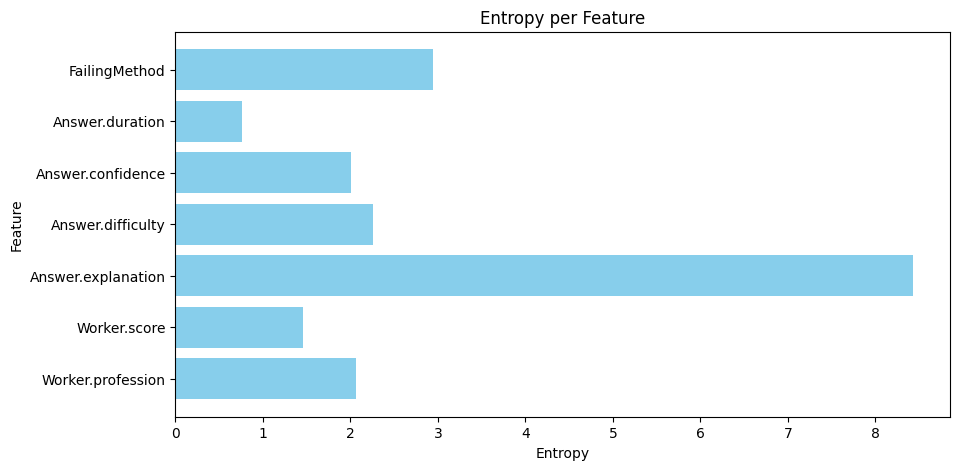

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def compute_entropy(values):
    """Computes entropy for a given list of values (words, categories, or binned numbers)."""
    freq_dist = Counter(values)  # Count occurrences
    total_values = sum(freq_dist.values())
    probabilities = [count / total_values for count in freq_dist.values()]
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
    return entropy

def compute_entropy_for_all_columns(df):
    """Computes entropy for each column in the dataframe."""
    entropy_results = {}

    for column in df.columns:
        values = df[column].dropna()  # Remove NaNs

        # If column is text, tokenize words
        if df[column].dtype == 'object':
            all_text = " ".join(values).lower()  # Merge all text
            tokens = all_text.split()  # Tokenize into words
            entropy_results[column] = compute_entropy(tokens)

        # If column is numerical, bin values before computing entropy
        elif np.issubdtype(df[column].dtype, np.number):
            binned_values = pd.cut(values, bins=10, duplicates='drop')  # Bin into 10 groups
            entropy_results[column] = compute_entropy(binned_values)

        # If column is categorical, compute entropy directly
        else:
            entropy_results[column] = compute_entropy(values)

    return entropy_results

entropy_values = compute_entropy_for_all_columns(new_data)

# Nicely formatted output
print("Entropy per feature:")
for feature, entropy in entropy_values.items():
    print(f"Feature: {feature}\nEntropy: {entropy}\n")

# Filter out features with entropy 0
features = list(entropy_values.keys())
entropy = list(entropy_values.values())

filtered_features = [f for f, e in zip(features, entropy) if e != 0.0]
filtered_entropy = [e for e in entropy if e != 0.0]

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.barh(filtered_features, filtered_entropy, color="skyblue")
plt.xlabel("Entropy")
plt.ylabel("Feature")
plt.title("Entropy per Feature")
plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Show plot
plt.show()


In [ ]:
import numpy as np
from collections import Counter

def compute_entropy_single_explanation(explanation):
    """
    Computes entropy for a single explanation based on word distribution.

    :param explanation: A single textual explanation (string)
    :return: Shannon entropy value
    """
    if not isinstance(explanation, str) or len(explanation.strip()) == 0:
        return 0  # Return 0 entropy for empty or non-string values

    # Step 1: Tokenize explanation into words (lowercase for consistency)
    tokens = explanation.lower().split()

    # Step 2: Compute frequency distribution of words
    freq_dist = Counter(tokens)

    # Step 3: Convert frequencies into probabilities
    total_tokens = sum(freq_dist.values())
    probabilities = [count / total_tokens for count in freq_dist.values()]

    # Step 4: Compute entropy using Shannon entropy formula
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)

    return entropy

# Assuming `similar_explanations` and `f1_scores` are available
# Example: similar_explanations = ["Explanation 1", "Explanation 2"], f1_scores = [0.9, 0.85]

# Compute entropy for each explanation in the `similar_explanations` list
entropy_values = {exp: compute_entropy_single_explanation(exp) for exp in similar_explanations}

# Sort the explanations by entropy in descending order
sorted_entropy_values = sorted(entropy_values.items(), key=lambda x: x[1], reverse=True)

# Display results with entropy and F1 score in order of highest diversity (entropy)
print("Sorted Entropy for Single Explanations (Highest Diversity First):")
for explanation, entropy in sorted_entropy_values:
    # Find the index of the explanation to get the corresponding F1 score
    index = similar_explanations.index(explanation)
    f1_score = f1_scores[index]
    print(f"Explanation: {explanation}\nBert F1 score: {f1_score}\nEntropy: {entropy}\n")


Sorted Entropy for Single Explanations (Highest Diversity First):
Explanation: YES. The issue is on line 279 (as I explained in my first question; of which I misunderstood that I was only being asked about the specific issue; not generalized issue). On line 279 the variable "minutesOffSet" is parameterized to throw an exception if it is < 0 or > 59. Line 279 should read "if (minutesOffset < -59 || minutesOffset > 59) {" because now the method can take in the number of minutes as a negative and will allow the method to properly progress to invoke/call further methods such as those asked about in the two previous questions.
Bert F1 score: 0.8827218413352966
Entropy: 6.0020480951008945

Explanation: The variable "minutesOffset" is checked incorrectly by the IF statement on line 279. Any negative value for "minutesOffset" will throw this exception; while the documentation states that "minutesOffset" can be negative in some cases.
Bert F1 score: 0.8805158138275146
Entropy: 4.748940047005428

In [ ]:
import itertools
import numpy as np
from collections import Counter

def compute_set_entropy(explanations):
    """Computes entropy for a whole set of explanations."""
    all_text = " ".join(explanations).lower()  # Merge all text
    words = all_text.split()  # Tokenize words
    freq_dist = Counter(words)  # Count occurrences
    total_words = sum(freq_dist.values())
    probabilities = [count / total_words for count in freq_dist.values()]
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
    return entropy

def generate_all_combinations(explanations):
    """Generate all possible non-empty subsets of the explanations."""
    all_combinations = []

    # Iterate over all possible combination sizes (from 1 to the length of the list)
    for r in range(1, len(explanations) + 1):
        # Get combinations of size 'r'
        comb = itertools.combinations(explanations, r)
        all_combinations.extend(comb)

    return all_combinations

# Generate all subsets from the similar_explanations list
all_possible_sets = generate_all_combinations(similar_explanations)

# Compute entropy for each subset and store them with their entropy values
entropy_with_subsets = [(subset, compute_set_entropy(subset)) for subset in all_possible_sets]

# Sort the subsets by entropy in descending order
sorted_entropy_sets = sorted(entropy_with_subsets, key=lambda x: x[1], reverse=True)

# Get the subset with the highest entropy (most diverse)
most_diverse_subset = sorted_entropy_sets[0][0]
highest_entropy = sorted_entropy_sets[0][1]

# Print the most diverse set (each explanation on a new line)
print("Most Diverse Set (Highest Entropy):")
print(f"Entropy: {highest_entropy}\n")
for explanation in most_diverse_subset:
    print(explanation)


Most Diverse Set (Highest Entropy):
Entropy: 6.551794385202084

There is a logical check for if minuteOffset is less than 0 or greater than 59 causing it to throw an exception because the value is out of bounds (negative number)
YES. The issue is on line 279 (as I explained in my first question; of which I misunderstood that I was only being asked about the specific issue; not generalized issue). On line 279 the variable "minutesOffSet" is parameterized to throw an exception if it is < 0 or > 59. Line 279 should read "if (minutesOffset < -59 || minutesOffset > 59) {" because now the method can take in the number of minutes as a negative and will allow the method to properly progress to invoke/call further methods such as those asked about in the two previous questions.
The variable "minutesOffset" is checked incorrectly by the IF statement on line 279. Any negative value for "minutesOffset" will throw this exception; while the documentation states that "minutesOffset" can be negative i

In [ ]:
gpt_prompt_readability = """Programmers have provided bug explanations.
Your goal is to unify them into a single, clear explanation that keeps necessary
technical details but avoids repeating the same info. Provide a short summary
focusing on the steps needed to fix the bug. Avoid headings or special formatting.
Additionally, aim for a Flesch Reading Ease Score between 60 and 80, and a
Flesch-Kincaid Grade Level between 8 and 12."""

gpt_prompt = """Programmers have provided bug explanations.
Your goal is to unify them into a single, clear explanation that keeps necessary
technical details but avoids repeating the same info. Provide a short summary
focusing on the steps needed to fix the bug. Avoid headings or special formatting."""

prompt = get_formatted_prompt(most_diverse_subset, gpt_prompt)
print(prompt)

Programmers have provided bug explanations.
Your goal is to unify them into a single, clear explanation that keeps necessary
technical details but avoids repeating the same info. Provide a short summary
focusing on the steps needed to fix the bug. Avoid headings or special formatting.

Here are the explanations, each separated by a newline:
There is a logical check for if minuteOffset is less than 0 or greater than 59 causing it to throw an exception because the value is out of bounds (negative number)

YES. The issue is on line 279 (as I explained in my first question; of which I misunderstood that I was only being asked about the specific issue; not generalized issue). On line 279 the variable "minutesOffSet" is parameterized to throw an exception if it is < 0 or > 59. Line 279 should read "if (minutesOffset < -59 || minutesOffset > 59) {" because now the method can take in the number of minutes as a negative and will allow the method to properly progress to invoke/call further metho

In [ ]:
# consolidated_candidate = """
# The bug occurs on line 910, where array[i] is dereferenced without checking for null, leading to a NullPointerException when the second element of the input array is null. To fix this, add a null check before calling getClass(), ensuring that if array[i] is null, classes[i] is set to null instead of attempting the method call. Modify line 910 as follows:
# classes[i] = (array[i] == null) ? null : array[i].getClass();
# """
consolidated_candidate = """The issue occurs on line 279, where the minutesOffset variable is incorrectly checked. The current condition throws an exception if minutesOffset is less than 0 or greater than 59. However, the documentation states that minutesOffset can be negative. To fix this, update the condition to if (minutesOffset < -59 || minutesOffset > 59), allowing negative values down to -59 while still preventing out-of-range inputs."""
P, R, F1_score = score([consolidated_candidate], [reference], lang='en', verbose=True)
fre_score = textstat.flesch_reading_ease(consolidated_candidate)
fre_level = textstat.flesch_kincaid_grade(consolidated_candidate)

print("SORTED DATA")
print("Consolidated examples: ", len(most_diverse_subset))
print("\nSCORES\n")
print("F1 score: ", F1_score)
print("Precision: ", P)
print("Recall: ", R)
print("\n\n")

print("Readability: ", fre_score, fre_level)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.78 seconds, 0.56 sentences/sec
SORTED DATA
Consolidated examples:  6

SCORES

F1 score:  tensor([0.9268])
Precision:  tensor([0.9182])
Recall:  tensor([0.9355])



Readability:  39.03 11.6


## Results for Bugtype HIT07_33
### gpt_prompt
The bug occurs on line 910, where array[i] is dereferenced without checking for null, leading to a NullPointerException when the second element of the input array is null. To fix this, add a null check before calling getClass(), ensuring that if array[i] is null, classes[i] is set to null instead of attempting the method call. Modify line 910 as follows:
classes[i] = (array[i] == null) ? null : array[i].getClass();

#### Scores
F1 score: 0.9304
Precision:  0.9324
Recall:  0.9283

Readability:  57.91 10.6

### gpt_prompt_readability
The bug occurs on line 910 when the code attempts to call getClass() on array[i] without checking if it's null. Since the second element of the input array is null, this results in a NullPointerException. The for loop itself is structured correctly, but it lacks a safeguard against null values. To fix the issue, add a null check before calling getClass(). Update line 910 to assign null to classes[i] when array[i] is null, preventing the exception. Use this approach: classes[i] = array[i] == null ? null : array[i].getClass();.

#### Scores
F1 score:  0.9277
Precision:  0.9279
Recall:  0.9274

Readability:  65.73 7.6


## Results for BugType HIT01_8
### gpt_prompt_readability
#### Score
F1 score:  0.9268
Precision:  0.9182
Recall:  0.9355

Readability:  39.03 11.6

### gpt_prompt
F1 score:  0.9126
Precision:  0.9046
Recall:  0.9207

Readability:  42.0 12.5